In [44]:
#basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

#data
import scipy.io as sio
from dataset import SURREALDataset, SittingDataset
from torch.utils.data import DataLoader

#pytorch
import torch
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
import torch.optim as optim
from torch.autograd import Variable

#models
from models import unet11

#train
from train import Trainer
from metrics import Soft_dice_loss

## SURREAL DATASET

In [2]:
dirr_train = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0'
dirr_test = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/test/run0'
dirr_val = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/val/run0'

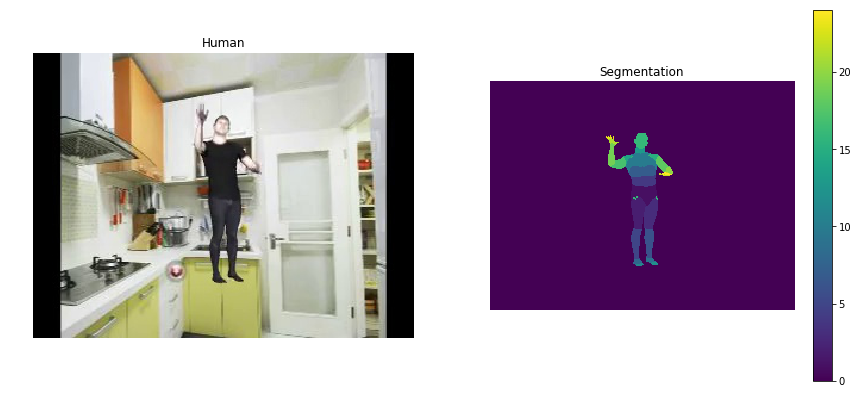

In [3]:
demonstrate_pic = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0/143_20/143_20_c0002frame1.jpg'
demonstrate_map = sio.loadmat('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0/143_20/143_20_c0002_segm.mat')['segm_1']

fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow(plt.imread(demonstrate_pic))
plt.title('Human')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(demonstrate_map)
plt.title('Segmentation')
plt.colorbar()
plt.axis("off");

In [4]:
def show_pics(imgs, col, row):
    fig = plt.figure(figsize=(5*col,5*row))
    for i in range(0, col*row):
        fig.add_subplot(row, col, i + 1)
        if i < len(imgs):
            plt.imshow(imgs[i])
            plt.title('Class ' + str(i+1))
        plt.axis("off")
        
def binarize_classes(classes, num):
    classes_bin = np.zeros((num, classes.shape[0], classes.shape[1]))
    for i in range(len(classes)):
        row = classes[i]
        for j in range(len(row)):
            classes_bin[int(row[j]), i, j] = 1.0
            
    return classes_bin

In [5]:
demonstrate_classes = binarize_classes(demonstrate_map, 25)

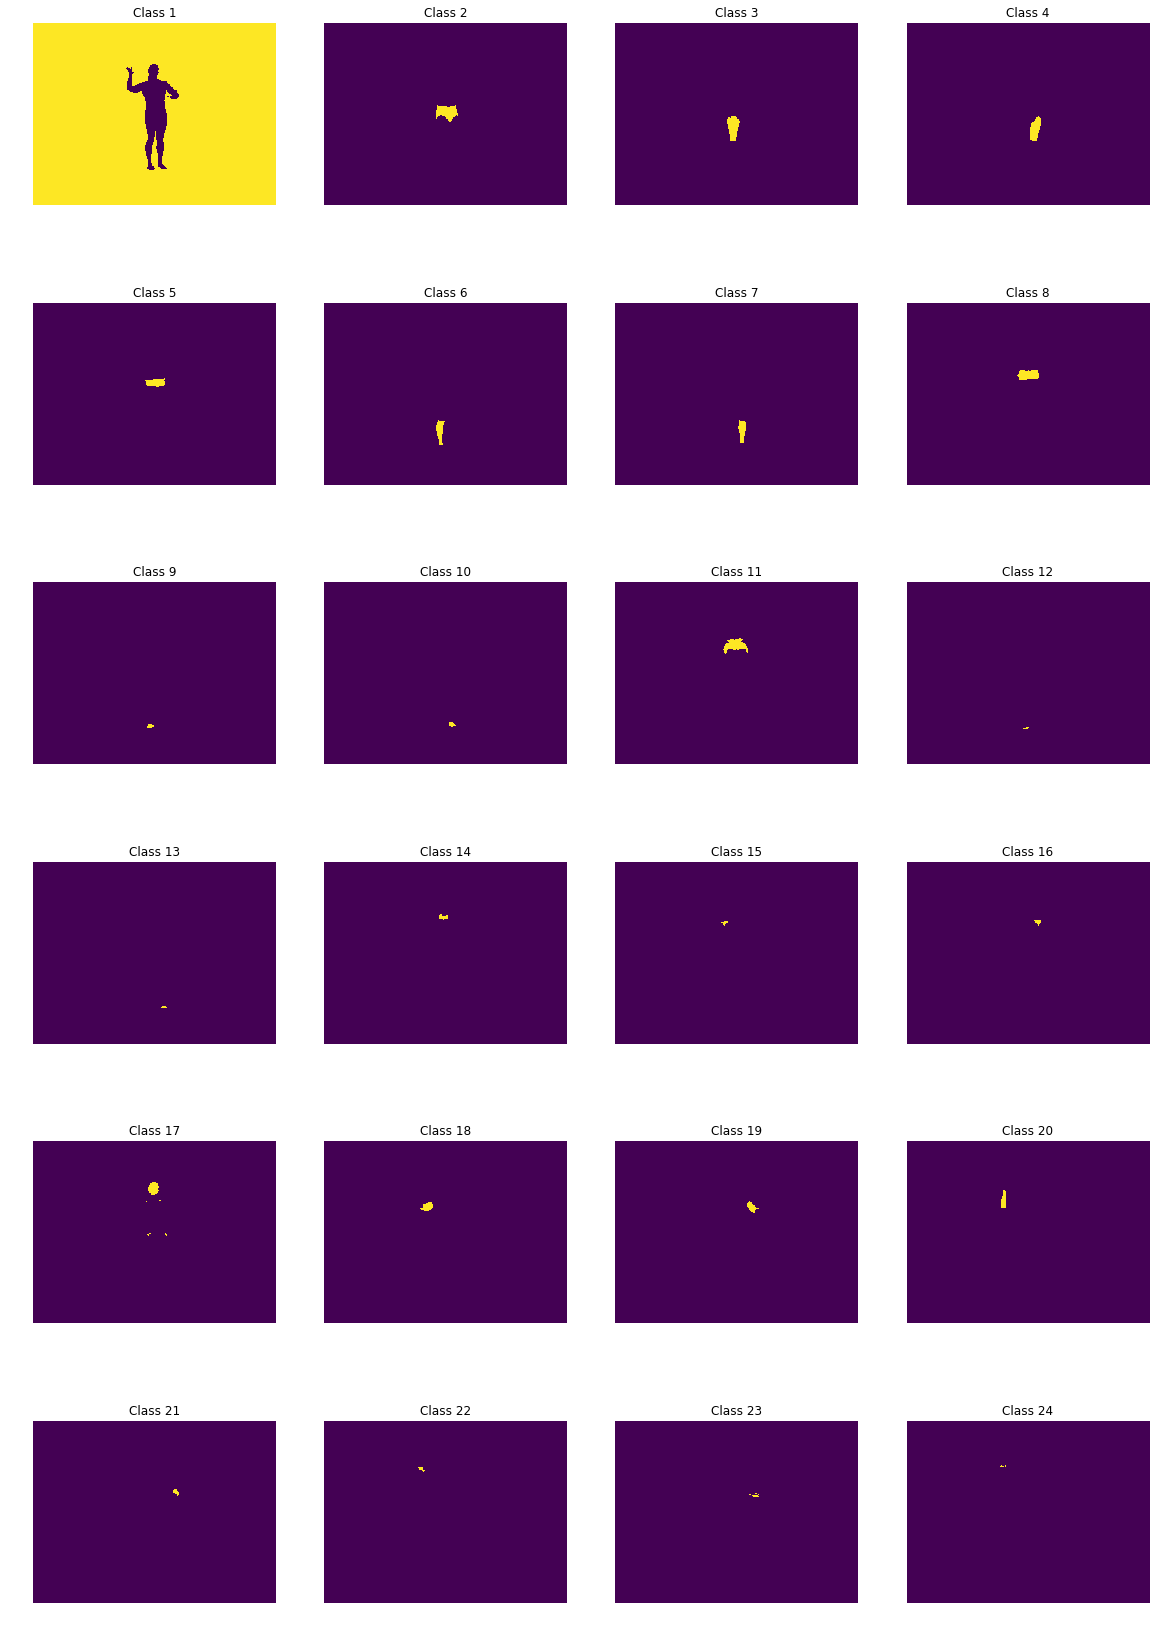

In [6]:
show_pics(demonstrate_classes, 4, 6)

## SITTING PEOPLE DATASET

In [7]:
sitting_dirr = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/img'

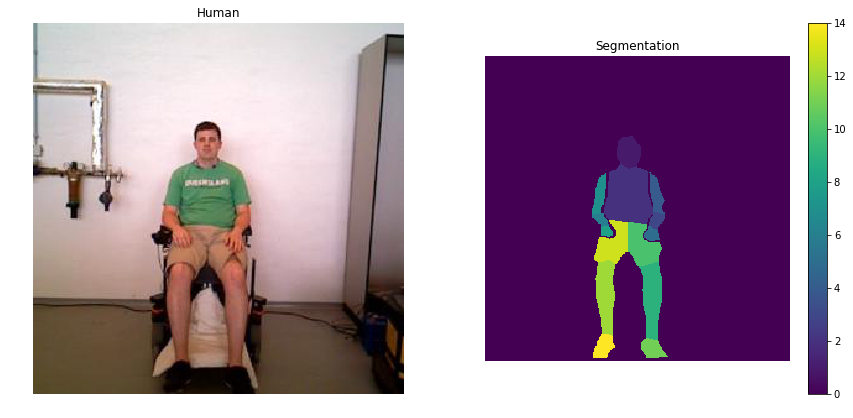

In [8]:
demonstrate_sit = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/img/image90.jpg'
demonstrate_map_sit = sio.loadmat('/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/masks/image90.mat')['M']

fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow(plt.imread(demonstrate_sit))
plt.title('Human')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(demonstrate_map_sit)
plt.title('Segmentation')
plt.colorbar()
plt.axis("off");

In [9]:
demonstrate_classes_sit = binarize_classes(demonstrate_map_sit, 15)

### Re-structed segmentation maps

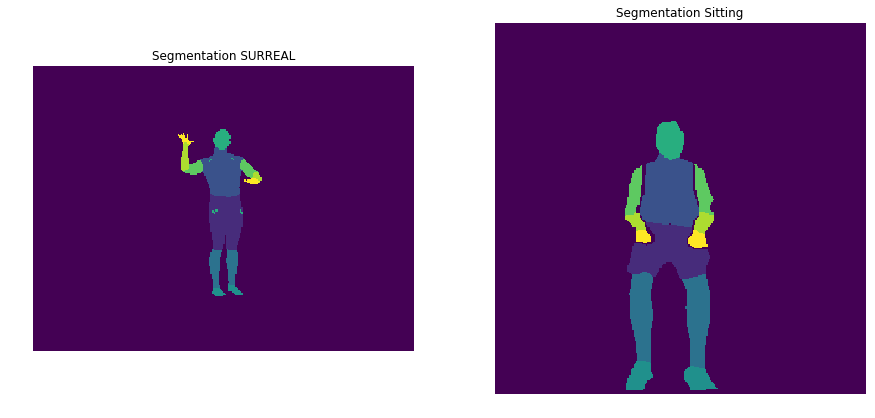

In [10]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow((demonstrate_classes[1] + demonstrate_classes[2] + demonstrate_classes[3]) +
          (demonstrate_classes[5] + demonstrate_classes[6])*3 +
          (demonstrate_classes[4] + demonstrate_classes[7] + demonstrate_classes[10] + demonstrate_classes[13] +demonstrate_classes[14] + demonstrate_classes[15])*2 +
          (demonstrate_classes[8] + demonstrate_classes[9] + demonstrate_classes[11] + demonstrate_classes[12])*4 +
           demonstrate_classes[16]*5 + (demonstrate_classes[17] + demonstrate_classes[18])*6 + 
          (demonstrate_classes[19] + demonstrate_classes[20])*7 +
          (demonstrate_classes[21] + demonstrate_classes[22] + demonstrate_classes[23] + demonstrate_classes[24])*8)

plt.title('Segmentation SURREAL')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(demonstrate_classes_sit[1]*5 + demonstrate_classes_sit[2]*2 + 
          (demonstrate_classes_sit[3] + demonstrate_classes_sit[6])*7 + 
          (demonstrate_classes_sit[4] + demonstrate_classes_sit[7])*6 +
          (demonstrate_classes_sit[5] + demonstrate_classes_sit[8])*8 +
          (demonstrate_classes_sit[9] + demonstrate_classes_sit[12])*3 + 
          (demonstrate_classes_sit[10] + demonstrate_classes_sit[13]) +
          (demonstrate_classes_sit[11] + demonstrate_classes_sit[14])*4)
plt.title('Segmentation Sitting')
plt.axis("off");

### SURREAL Dataset for pre-training.

In [11]:
transf = Compose([
    ToTensor()
])

dset_train = SURREALDataset(dirr_train, 9, transf, identifier='restructed', lengt=10000)
dset_test = SURREALDataset(dirr_test, 9, transf, identifier='restructed', lengt=10000)
dset_val = SURREALDataset(dirr_val, 9, transf, identifier='restructed', lengt=10000)

In [12]:
batch_sz = 4
train_loader = DataLoader(dset_train, batch_size=batch_sz, shuffle=False)
test_loader = DataLoader(dset_test, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(dset_val, batch_size=batch_sz, shuffle=True)

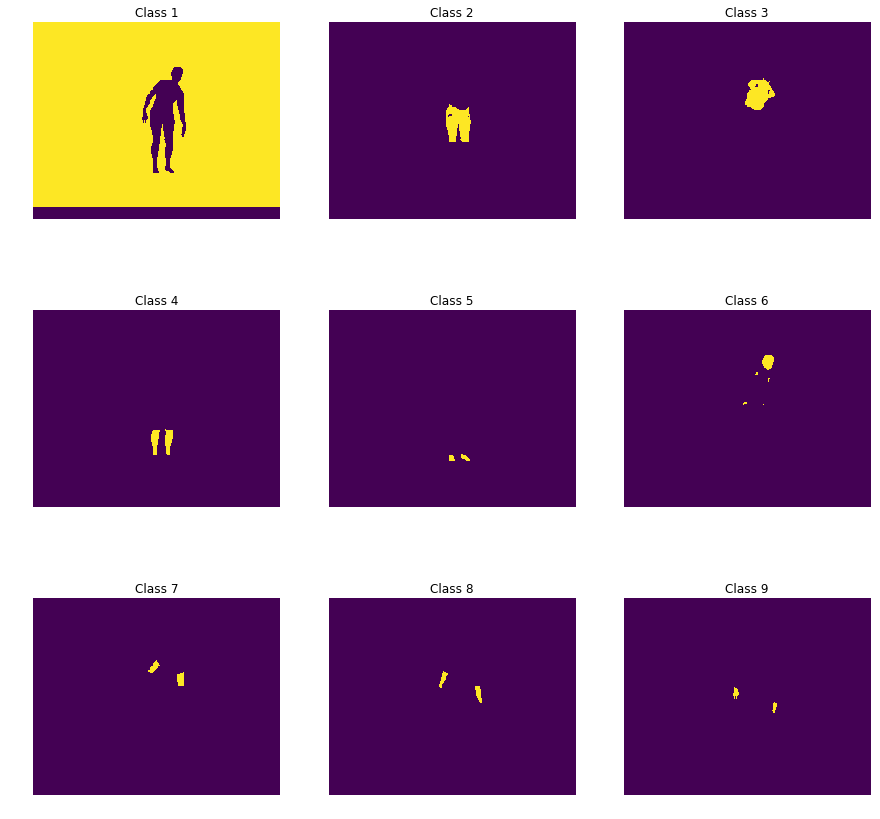

In [13]:
inputs_sur, classes_sur = next(iter(train_loader))
show_pics(classes_sur[0], 3, 3 )

### Sitting People Dataset.

In [14]:
dset_sitting = SittingDataset(sitting_dirr, 9, transf, identifier='restructed')
sitting_loader = DataLoader(dset_sitting, batch_size=batch_sz, shuffle=True)

In [15]:
inputs_sit, classes_sit = next(iter(sitting_loader))

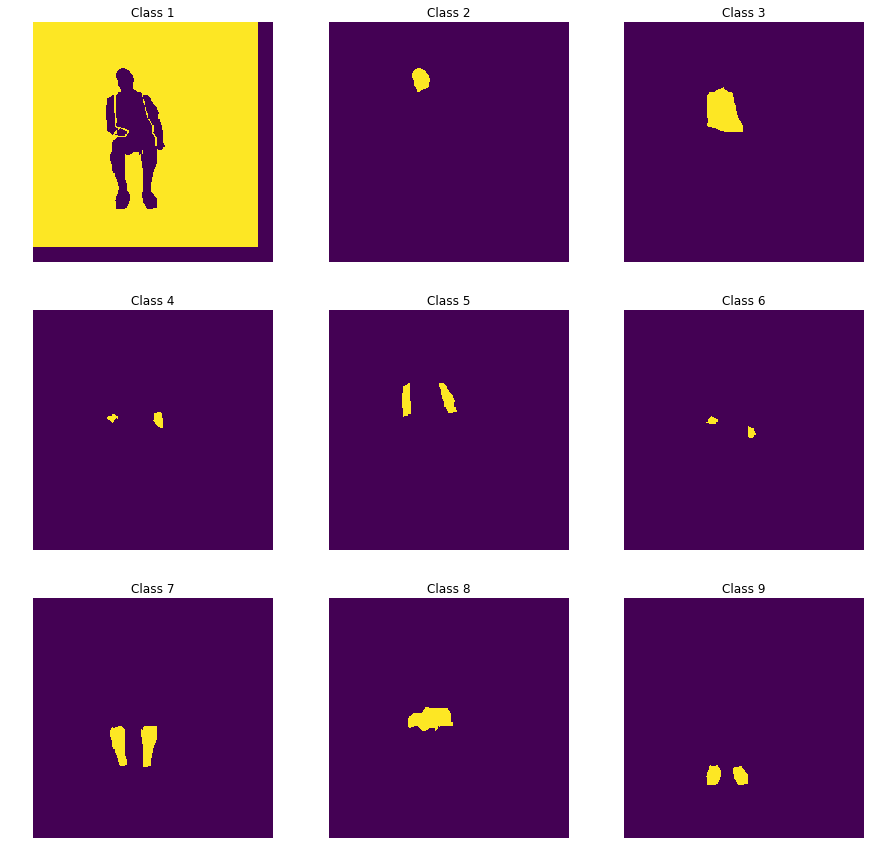

In [16]:
show_pics(classes_sit[0], 3, 3)

## TernausNet

In [17]:
num_classes = 9
num_epochs = 10
model = unet11(num_classes, 'carvana')

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=1,
    verbose=True,
    threshold=0.1
)

In [19]:
loss = Soft_dice_loss(smooth=1e-15)

In [20]:
train = Trainer(model, loss, train_loader, optimizer, num_epochs,
                save_dir='params/', save_freq=1, verbosity=2,
                gpu=torch.cuda.is_available(), identifier='ternaus', valid_data_loader=val_loader)

In [23]:
train.train()

Train Epoch: 1 [0/11952 (0%)] Loss: 0.109940355
Train Epoch: 1 [8/11952 (0%)] Loss: 0.109795146
Train Epoch: 1 [16/11952 (0%)] Loss: 0.108981182
Train Epoch: 1 [24/11952 (0%)] Loss: 0.109730842
Train Epoch: 1 [32/11952 (0%)] Loss: 0.110036795
Train Epoch: 1 [40/11952 (0%)] Loss: 0.110213661
Train Epoch: 1 [48/11952 (0%)] Loss: 0.110112209
Train Epoch: 1 [56/11952 (0%)] Loss: 0.110406440
Train Epoch: 1 [64/11952 (1%)] Loss: 0.110424173
Train Epoch: 1 [72/11952 (1%)] Loss: 0.109885518
Train Epoch: 1 [80/11952 (1%)] Loss: 0.109970011
Train Epoch: 1 [88/11952 (1%)] Loss: 0.108897637
Train Epoch: 1 [96/11952 (1%)] Loss: 0.110256317
Train Epoch: 1 [104/11952 (1%)] Loss: 0.109509245
Train Epoch: 1 [112/11952 (1%)] Loss: 0.109797066
Train Epoch: 1 [120/11952 (1%)] Loss: 0.109634666
Train Epoch: 1 [128/11952 (1%)] Loss: 0.110121899
Train Epoch: 1 [136/11952 (1%)] Loss: 0.109626738
Train Epoch: 1 [144/11952 (1%)] Loss: 0.109270589
Train Epoch: 1 [152/11952 (1%)] Loss: 0.109980261
Train Epoch: 1 

Train Epoch: 1 [1304/11952 (11%)] Loss: 0.094319166
Train Epoch: 1 [1312/11952 (11%)] Loss: 0.094179578
Train Epoch: 1 [1320/11952 (11%)] Loss: 0.092769390
Train Epoch: 1 [1328/11952 (11%)] Loss: 0.094584545
Train Epoch: 1 [1336/11952 (11%)] Loss: 0.093916325
Train Epoch: 1 [1344/11952 (11%)] Loss: 0.095033328
Train Epoch: 1 [1352/11952 (11%)] Loss: 0.094363455
Train Epoch: 1 [1360/11952 (11%)] Loss: 0.094347972
Train Epoch: 1 [1368/11952 (11%)] Loss: 0.092976812
Train Epoch: 1 [1376/11952 (12%)] Loss: 0.094000174
Train Epoch: 1 [1384/11952 (12%)] Loss: 0.095716753
Train Epoch: 1 [1392/11952 (12%)] Loss: 0.093523883
Train Epoch: 1 [1400/11952 (12%)] Loss: 0.095089783
Train Epoch: 1 [1408/11952 (12%)] Loss: 0.093971326
Train Epoch: 1 [1416/11952 (12%)] Loss: 0.094837277
Train Epoch: 1 [1424/11952 (12%)] Loss: 0.093393034
Train Epoch: 1 [1432/11952 (12%)] Loss: 0.093805902
Train Epoch: 1 [1440/11952 (12%)] Loss: 0.094558020
Train Epoch: 1 [1448/11952 (12%)] Loss: 0.096431323
Train Epoch:

Train Epoch: 1 [2568/11952 (21%)] Loss: 0.094252951
Train Epoch: 1 [2576/11952 (22%)] Loss: 0.095937269
Train Epoch: 1 [2584/11952 (22%)] Loss: 0.093332242
Train Epoch: 1 [2592/11952 (22%)] Loss: 0.095456905
Train Epoch: 1 [2600/11952 (22%)] Loss: 0.096631730
Train Epoch: 1 [2608/11952 (22%)] Loss: 0.095435311
Train Epoch: 1 [2616/11952 (22%)] Loss: 0.093630192
Train Epoch: 1 [2624/11952 (22%)] Loss: 0.095912659
Train Epoch: 1 [2632/11952 (22%)] Loss: 0.095622478
Train Epoch: 1 [2640/11952 (22%)] Loss: 0.094968155
Train Epoch: 1 [2648/11952 (22%)] Loss: 0.092879765
Train Epoch: 1 [2656/11952 (22%)] Loss: 0.093439458
Train Epoch: 1 [2664/11952 (22%)] Loss: 0.096893657
Train Epoch: 1 [2672/11952 (22%)] Loss: 0.094437071
Train Epoch: 1 [2680/11952 (22%)] Loss: 0.092758950
Train Epoch: 1 [2688/11952 (22%)] Loss: 0.095259965
Train Epoch: 1 [2696/11952 (23%)] Loss: 0.095398845
Train Epoch: 1 [2704/11952 (23%)] Loss: 0.095195999
Train Epoch: 1 [2712/11952 (23%)] Loss: 0.093814156
Train Epoch:

Train Epoch: 1 [3832/11952 (32%)] Loss: 0.088958562
Train Epoch: 1 [3840/11952 (32%)] Loss: 0.092567118
Train Epoch: 1 [3848/11952 (32%)] Loss: 0.091168039
Train Epoch: 1 [3856/11952 (32%)] Loss: 0.088741100
Train Epoch: 1 [3864/11952 (32%)] Loss: 0.090897102
Train Epoch: 1 [3872/11952 (32%)] Loss: 0.089070540
Train Epoch: 1 [3880/11952 (32%)] Loss: 0.089380706
Train Epoch: 1 [3888/11952 (33%)] Loss: 0.089204576
Train Epoch: 1 [3896/11952 (33%)] Loss: 0.089337745
Train Epoch: 1 [3904/11952 (33%)] Loss: 0.088580459
Train Epoch: 1 [3912/11952 (33%)] Loss: 0.086455481
Train Epoch: 1 [3920/11952 (33%)] Loss: 0.087246638
Train Epoch: 1 [3928/11952 (33%)] Loss: 0.089879205
Train Epoch: 1 [3936/11952 (33%)] Loss: 0.088904106
Train Epoch: 1 [3944/11952 (33%)] Loss: 0.087515037
Train Epoch: 1 [3952/11952 (33%)] Loss: 0.087653188
Train Epoch: 1 [3960/11952 (33%)] Loss: 0.087080339
Train Epoch: 1 [3968/11952 (33%)] Loss: 0.086577966
Train Epoch: 1 [3976/11952 (33%)] Loss: 0.086742936
Train Epoch:

Train Epoch: 1 [5096/11952 (43%)] Loss: 0.088297146
Train Epoch: 1 [5104/11952 (43%)] Loss: 0.088346927
Train Epoch: 1 [5112/11952 (43%)] Loss: 0.087275454
Train Epoch: 1 [5120/11952 (43%)] Loss: 0.087939365
Train Epoch: 1 [5128/11952 (43%)] Loss: 0.088771501
Train Epoch: 1 [5136/11952 (43%)] Loss: 0.089835924
Train Epoch: 1 [5144/11952 (43%)] Loss: 0.087192137
Train Epoch: 1 [5152/11952 (43%)] Loss: 0.088756080
Train Epoch: 1 [5160/11952 (43%)] Loss: 0.091500250
Train Epoch: 1 [5168/11952 (43%)] Loss: 0.089460465
Train Epoch: 1 [5176/11952 (43%)] Loss: 0.093472950
Train Epoch: 1 [5184/11952 (43%)] Loss: 0.091437230
Train Epoch: 1 [5192/11952 (43%)] Loss: 0.094226063
Train Epoch: 1 [5200/11952 (44%)] Loss: 0.091137209
Train Epoch: 1 [5208/11952 (44%)] Loss: 0.089099111
Train Epoch: 1 [5216/11952 (44%)] Loss: 0.091500816
Train Epoch: 1 [5224/11952 (44%)] Loss: 0.088910641
Train Epoch: 1 [5232/11952 (44%)] Loss: 0.088414718
Train Epoch: 1 [5240/11952 (44%)] Loss: 0.086593731
Train Epoch:

Train Epoch: 1 [6360/11952 (53%)] Loss: 0.080666938
Train Epoch: 1 [6368/11952 (53%)] Loss: 0.081556573
Train Epoch: 1 [6376/11952 (53%)] Loss: 0.079221729
Train Epoch: 1 [6384/11952 (53%)] Loss: 0.078551509
Train Epoch: 1 [6392/11952 (53%)] Loss: 0.082396225
Train Epoch: 1 [6400/11952 (54%)] Loss: 0.078891740
Train Epoch: 1 [6408/11952 (54%)] Loss: 0.081380919
Train Epoch: 1 [6416/11952 (54%)] Loss: 0.080492487
Train Epoch: 1 [6424/11952 (54%)] Loss: 0.079655875
Train Epoch: 1 [6432/11952 (54%)] Loss: 0.081770727
Train Epoch: 1 [6440/11952 (54%)] Loss: 0.079893779
Train Epoch: 1 [6448/11952 (54%)] Loss: 0.078737742
Train Epoch: 1 [6456/11952 (54%)] Loss: 0.081227585
Train Epoch: 1 [6464/11952 (54%)] Loss: 0.078237147
Train Epoch: 1 [6472/11952 (54%)] Loss: 0.077389323
Train Epoch: 1 [6480/11952 (54%)] Loss: 0.078275623
Train Epoch: 1 [6488/11952 (54%)] Loss: 0.080126177
Train Epoch: 1 [6496/11952 (54%)] Loss: 0.078522061
Train Epoch: 1 [6504/11952 (54%)] Loss: 0.079335277
Train Epoch:

Train Epoch: 1 [7624/11952 (64%)] Loss: 0.079547168
Train Epoch: 1 [7632/11952 (64%)] Loss: 0.075094393
Train Epoch: 1 [7640/11952 (64%)] Loss: 0.078201258
Train Epoch: 1 [7648/11952 (64%)] Loss: 0.079054887
Train Epoch: 1 [7656/11952 (64%)] Loss: 0.078134766
Train Epoch: 1 [7664/11952 (64%)] Loss: 0.075278195
Train Epoch: 1 [7672/11952 (64%)] Loss: 0.075454669
Train Epoch: 1 [7680/11952 (64%)] Loss: 0.075769834
Train Epoch: 1 [7688/11952 (64%)] Loss: 0.075918659
Train Epoch: 1 [7696/11952 (64%)] Loss: 0.073310491
Train Epoch: 1 [7704/11952 (64%)] Loss: 0.073919186
Train Epoch: 1 [7712/11952 (65%)] Loss: 0.076035039
Train Epoch: 1 [7720/11952 (65%)] Loss: 0.073855560
Train Epoch: 1 [7728/11952 (65%)] Loss: 0.073479806
Train Epoch: 1 [7736/11952 (65%)] Loss: 0.074092394
Train Epoch: 1 [7744/11952 (65%)] Loss: 0.075549535
Train Epoch: 1 [7752/11952 (65%)] Loss: 0.076398083
Train Epoch: 1 [7760/11952 (65%)] Loss: 0.073511211
Train Epoch: 1 [7768/11952 (65%)] Loss: 0.075352003
Train Epoch:

Train Epoch: 1 [8888/11952 (74%)] Loss: 0.074002009
Train Epoch: 1 [8896/11952 (74%)] Loss: 0.075270162
Train Epoch: 1 [8904/11952 (74%)] Loss: 0.077884397
Train Epoch: 1 [8912/11952 (75%)] Loss: 0.073762778
Train Epoch: 1 [8920/11952 (75%)] Loss: 0.072853645
Train Epoch: 1 [8928/11952 (75%)] Loss: 0.075095988
Train Epoch: 1 [8936/11952 (75%)] Loss: 0.076298891
Train Epoch: 1 [8944/11952 (75%)] Loss: 0.076495777
Train Epoch: 1 [8952/11952 (75%)] Loss: 0.075703627
Train Epoch: 1 [8960/11952 (75%)] Loss: 0.074952895
Train Epoch: 1 [8968/11952 (75%)] Loss: 0.072273526
Train Epoch: 1 [8976/11952 (75%)] Loss: 0.073304381
Train Epoch: 1 [8984/11952 (75%)] Loss: 0.072139829
Train Epoch: 1 [8992/11952 (75%)] Loss: 0.075092363
Train Epoch: 1 [9000/11952 (75%)] Loss: 0.074032422
Train Epoch: 1 [9008/11952 (75%)] Loss: 0.074716565
Train Epoch: 1 [9016/11952 (75%)] Loss: 0.072708861
Train Epoch: 1 [9024/11952 (76%)] Loss: 0.073384969
Train Epoch: 1 [9032/11952 (76%)] Loss: 0.077348519
Train Epoch:

Train Epoch: 1 [10152/11952 (85%)] Loss: 0.083884717
Train Epoch: 1 [10160/11952 (85%)] Loss: 0.076938557
Train Epoch: 1 [10168/11952 (85%)] Loss: 0.087997401
Train Epoch: 1 [10176/11952 (85%)] Loss: 0.085735068
Train Epoch: 1 [10184/11952 (85%)] Loss: 0.079873095
Train Epoch: 1 [10192/11952 (85%)] Loss: 0.078649943
Train Epoch: 1 [10200/11952 (85%)] Loss: 0.076345515
Train Epoch: 1 [10208/11952 (85%)] Loss: 0.075443741
Train Epoch: 1 [10216/11952 (85%)] Loss: 0.080531959
Train Epoch: 1 [10224/11952 (86%)] Loss: 0.079055860
Train Epoch: 1 [10232/11952 (86%)] Loss: 0.077069024
Train Epoch: 1 [10240/11952 (86%)] Loss: 0.083974596
Train Epoch: 1 [10248/11952 (86%)] Loss: 0.079457278
Train Epoch: 1 [10256/11952 (86%)] Loss: 0.078324647
Train Epoch: 1 [10264/11952 (86%)] Loss: 0.077664939
Train Epoch: 1 [10272/11952 (86%)] Loss: 0.080010819
Train Epoch: 1 [10280/11952 (86%)] Loss: 0.077278288
Train Epoch: 1 [10288/11952 (86%)] Loss: 0.083770222
Train Epoch: 1 [10296/11952 (86%)] Loss: 0.081

Train Epoch: 1 [11392/11952 (95%)] Loss: 0.080789161
Train Epoch: 1 [11400/11952 (95%)] Loss: 0.078205384
Train Epoch: 1 [11408/11952 (95%)] Loss: 0.077663796
Train Epoch: 1 [11416/11952 (96%)] Loss: 0.070911111
Train Epoch: 1 [11424/11952 (96%)] Loss: 0.074315669
Train Epoch: 1 [11432/11952 (96%)] Loss: 0.078957991
Train Epoch: 1 [11440/11952 (96%)] Loss: 0.075643505
Train Epoch: 1 [11448/11952 (96%)] Loss: 0.078045719
Train Epoch: 1 [11456/11952 (96%)] Loss: 0.074029495
Train Epoch: 1 [11464/11952 (96%)] Loss: 0.082035973
Train Epoch: 1 [11472/11952 (96%)] Loss: 0.078221835
Train Epoch: 1 [11480/11952 (96%)] Loss: 0.077064903
Train Epoch: 1 [11488/11952 (96%)] Loss: 0.074806608
Train Epoch: 1 [11496/11952 (96%)] Loss: 0.080158996
Train Epoch: 1 [11504/11952 (96%)] Loss: 0.077047962
Train Epoch: 1 [11512/11952 (96%)] Loss: 0.084592593
Train Epoch: 1 [11520/11952 (96%)] Loss: 0.079534598
Train Epoch: 1 [11528/11952 (96%)] Loss: 0.074150495
Train Epoch: 1 [11536/11952 (97%)] Loss: 0.079

Train Epoch: 2 [704/11952 (6%)] Loss: 0.080483679
Train Epoch: 2 [712/11952 (6%)] Loss: 0.075822001
Train Epoch: 2 [720/11952 (6%)] Loss: 0.077553534
Train Epoch: 2 [728/11952 (6%)] Loss: 0.073341153
Train Epoch: 2 [736/11952 (6%)] Loss: 0.073552809
Train Epoch: 2 [744/11952 (6%)] Loss: 0.078575280
Train Epoch: 2 [752/11952 (6%)] Loss: 0.073755652
Train Epoch: 2 [760/11952 (6%)] Loss: 0.073852431
Train Epoch: 2 [768/11952 (6%)] Loss: 0.077987449
Train Epoch: 2 [776/11952 (6%)] Loss: 0.075980047
Train Epoch: 2 [784/11952 (7%)] Loss: 0.075901097
Train Epoch: 2 [792/11952 (7%)] Loss: 0.073008729
Train Epoch: 2 [800/11952 (7%)] Loss: 0.073008796
Train Epoch: 2 [808/11952 (7%)] Loss: 0.074631468
Train Epoch: 2 [816/11952 (7%)] Loss: 0.075526892
Train Epoch: 2 [824/11952 (7%)] Loss: 0.074306097
Train Epoch: 2 [832/11952 (7%)] Loss: 0.077670731
Train Epoch: 2 [840/11952 (7%)] Loss: 0.075999234
Train Epoch: 2 [848/11952 (7%)] Loss: 0.073752772
Train Epoch: 2 [856/11952 (7%)] Loss: 0.073107019


Train Epoch: 2 [1984/11952 (17%)] Loss: 0.069821937
Train Epoch: 2 [1992/11952 (17%)] Loss: 0.067649638
Train Epoch: 2 [2000/11952 (17%)] Loss: 0.069713907
Train Epoch: 2 [2008/11952 (17%)] Loss: 0.069099020
Train Epoch: 2 [2016/11952 (17%)] Loss: 0.068421903
Train Epoch: 2 [2024/11952 (17%)] Loss: 0.067825432
Train Epoch: 2 [2032/11952 (17%)] Loss: 0.067656368
Train Epoch: 2 [2040/11952 (17%)] Loss: 0.068090148
Train Epoch: 2 [2048/11952 (17%)] Loss: 0.066970334
Train Epoch: 2 [2056/11952 (17%)] Loss: 0.067414591
Train Epoch: 2 [2064/11952 (17%)] Loss: 0.066687908
Train Epoch: 2 [2072/11952 (17%)] Loss: 0.068241607
Train Epoch: 2 [2080/11952 (17%)] Loss: 0.071129069
Train Epoch: 2 [2088/11952 (17%)] Loss: 0.067874667
Train Epoch: 2 [2096/11952 (18%)] Loss: 0.071414158
Train Epoch: 2 [2104/11952 (18%)] Loss: 0.068201852
Train Epoch: 2 [2112/11952 (18%)] Loss: 0.068223102
Train Epoch: 2 [2120/11952 (18%)] Loss: 0.067271488
Train Epoch: 2 [2128/11952 (18%)] Loss: 0.067601042
Train Epoch:

Train Epoch: 2 [3248/11952 (27%)] Loss: 0.075647387
Train Epoch: 2 [3256/11952 (27%)] Loss: 0.072402727
Train Epoch: 2 [3264/11952 (27%)] Loss: 0.075904757
Train Epoch: 2 [3272/11952 (27%)] Loss: 0.070590224
Train Epoch: 2 [3280/11952 (27%)] Loss: 0.079462828
Train Epoch: 2 [3288/11952 (28%)] Loss: 0.077976604
Train Epoch: 2 [3296/11952 (28%)] Loss: 0.073120165
Train Epoch: 2 [3304/11952 (28%)] Loss: 0.076362415
Train Epoch: 2 [3312/11952 (28%)] Loss: 0.070356937
Train Epoch: 2 [3320/11952 (28%)] Loss: 0.071882780
Train Epoch: 2 [3328/11952 (28%)] Loss: 0.074281703
Train Epoch: 2 [3336/11952 (28%)] Loss: 0.075164762
Train Epoch: 2 [3344/11952 (28%)] Loss: 0.071568887
Train Epoch: 2 [3352/11952 (28%)] Loss: 0.073385570
Train Epoch: 2 [3360/11952 (28%)] Loss: 0.072604740
Train Epoch: 2 [3368/11952 (28%)] Loss: 0.071633103
Train Epoch: 2 [3376/11952 (28%)] Loss: 0.070888097
Train Epoch: 2 [3384/11952 (28%)] Loss: 0.071897264
Train Epoch: 2 [3392/11952 (28%)] Loss: 0.071365397
Train Epoch:

Train Epoch: 2 [4512/11952 (38%)] Loss: 0.069741867
Train Epoch: 2 [4520/11952 (38%)] Loss: 0.068839128
Train Epoch: 2 [4528/11952 (38%)] Loss: 0.070052089
Train Epoch: 2 [4536/11952 (38%)] Loss: 0.070588498
Train Epoch: 2 [4544/11952 (38%)] Loss: 0.070240767
Train Epoch: 2 [4552/11952 (38%)] Loss: 0.071872105
Train Epoch: 2 [4560/11952 (38%)] Loss: 0.072154149
Train Epoch: 2 [4568/11952 (38%)] Loss: 0.072530015
Train Epoch: 2 [4576/11952 (38%)] Loss: 0.067257587
Train Epoch: 2 [4584/11952 (38%)] Loss: 0.068355254
Train Epoch: 2 [4592/11952 (38%)] Loss: 0.067477042
Train Epoch: 2 [4600/11952 (38%)] Loss: 0.069378503
Train Epoch: 2 [4608/11952 (39%)] Loss: 0.065899280
Train Epoch: 2 [4616/11952 (39%)] Loss: 0.065970800
Train Epoch: 2 [4624/11952 (39%)] Loss: 0.068512704
Train Epoch: 2 [4632/11952 (39%)] Loss: 0.065836848
Train Epoch: 2 [4640/11952 (39%)] Loss: 0.063612471
Train Epoch: 2 [4648/11952 (39%)] Loss: 0.064620795
Train Epoch: 2 [4656/11952 (39%)] Loss: 0.064019711
Train Epoch:

Train Epoch: 2 [5776/11952 (48%)] Loss: 0.066625705
Train Epoch: 2 [5784/11952 (48%)] Loss: 0.067272305
Train Epoch: 2 [5792/11952 (48%)] Loss: 0.065557124
Train Epoch: 2 [5800/11952 (49%)] Loss: 0.068190175
Train Epoch: 2 [5808/11952 (49%)] Loss: 0.070351308
Train Epoch: 2 [5816/11952 (49%)] Loss: 0.068095796
Train Epoch: 2 [5824/11952 (49%)] Loss: 0.066473844
Train Epoch: 2 [5832/11952 (49%)] Loss: 0.065818986
Train Epoch: 2 [5840/11952 (49%)] Loss: 0.064898216
Train Epoch: 2 [5848/11952 (49%)] Loss: 0.066393038
Train Epoch: 2 [5856/11952 (49%)] Loss: 0.065890023
Train Epoch: 2 [5864/11952 (49%)] Loss: 0.065856148
Train Epoch: 2 [5872/11952 (49%)] Loss: 0.065047353
Train Epoch: 2 [5880/11952 (49%)] Loss: 0.066652822
Train Epoch: 2 [5888/11952 (49%)] Loss: 0.074112447
Train Epoch: 2 [5896/11952 (49%)] Loss: 0.069347799
Train Epoch: 2 [5904/11952 (49%)] Loss: 0.069071332
Train Epoch: 2 [5912/11952 (49%)] Loss: 0.067140654
Train Epoch: 2 [5920/11952 (50%)] Loss: 0.068738966
Train Epoch:

Train Epoch: 2 [7040/11952 (59%)] Loss: 0.060967500
Train Epoch: 2 [7048/11952 (59%)] Loss: 0.061220084
Train Epoch: 2 [7056/11952 (59%)] Loss: 0.059680030
Train Epoch: 2 [7064/11952 (59%)] Loss: 0.060225095
Train Epoch: 2 [7072/11952 (59%)] Loss: 0.066922085
Train Epoch: 2 [7080/11952 (59%)] Loss: 0.069010803
Train Epoch: 2 [7088/11952 (59%)] Loss: 0.063541183
Train Epoch: 2 [7096/11952 (59%)] Loss: 0.063386502
Train Epoch: 2 [7104/11952 (59%)] Loss: 0.068569255
Train Epoch: 2 [7112/11952 (60%)] Loss: 0.059076118
Train Epoch: 2 [7120/11952 (60%)] Loss: 0.064488609
Train Epoch: 2 [7128/11952 (60%)] Loss: 0.064738673
Train Epoch: 2 [7136/11952 (60%)] Loss: 0.062739607
Train Epoch: 2 [7144/11952 (60%)] Loss: 0.069607993
Train Epoch: 2 [7152/11952 (60%)] Loss: 0.064931393
Train Epoch: 2 [7160/11952 (60%)] Loss: 0.066100953
Train Epoch: 2 [7168/11952 (60%)] Loss: 0.071879831
Train Epoch: 2 [7176/11952 (60%)] Loss: 0.063731448
Train Epoch: 2 [7184/11952 (60%)] Loss: 0.059670334
Train Epoch:

Train Epoch: 2 [8304/11952 (69%)] Loss: 0.060582126
Train Epoch: 2 [8312/11952 (70%)] Loss: 0.061959470
Train Epoch: 2 [8320/11952 (70%)] Loss: 0.061977121
Train Epoch: 2 [8328/11952 (70%)] Loss: 0.062413565
Train Epoch: 2 [8336/11952 (70%)] Loss: 0.061563401
Train Epoch: 2 [8344/11952 (70%)] Loss: 0.061500249
Train Epoch: 2 [8352/11952 (70%)] Loss: 0.059397033
Train Epoch: 2 [8360/11952 (70%)] Loss: 0.059135996
Train Epoch: 2 [8368/11952 (70%)] Loss: 0.064393290
Train Epoch: 2 [8376/11952 (70%)] Loss: 0.063625625
Train Epoch: 2 [8384/11952 (70%)] Loss: 0.063512420
Train Epoch: 2 [8392/11952 (70%)] Loss: 0.062731990
Train Epoch: 2 [8400/11952 (70%)] Loss: 0.063532309
Train Epoch: 2 [8408/11952 (70%)] Loss: 0.061580535
Train Epoch: 2 [8416/11952 (70%)] Loss: 0.061588273
Train Epoch: 2 [8424/11952 (70%)] Loss: 0.062356303
Train Epoch: 2 [8432/11952 (71%)] Loss: 0.059702915
Train Epoch: 2 [8440/11952 (71%)] Loss: 0.059505637
Train Epoch: 2 [8448/11952 (71%)] Loss: 0.061360075
Train Epoch:

Train Epoch: 2 [9568/11952 (80%)] Loss: 0.055624412
Train Epoch: 2 [9576/11952 (80%)] Loss: 0.060536653
Train Epoch: 2 [9584/11952 (80%)] Loss: 0.057273503
Train Epoch: 2 [9592/11952 (80%)] Loss: 0.058042119
Train Epoch: 2 [9600/11952 (80%)] Loss: 0.056075042
Train Epoch: 2 [9608/11952 (80%)] Loss: 0.057286904
Train Epoch: 2 [9616/11952 (80%)] Loss: 0.055532144
Train Epoch: 2 [9624/11952 (81%)] Loss: 0.055916986
Train Epoch: 2 [9632/11952 (81%)] Loss: 0.059001172
Train Epoch: 2 [9640/11952 (81%)] Loss: 0.058079015
Train Epoch: 2 [9648/11952 (81%)] Loss: 0.057471554
Train Epoch: 2 [9656/11952 (81%)] Loss: 0.058744736
Train Epoch: 2 [9664/11952 (81%)] Loss: 0.058041825
Train Epoch: 2 [9672/11952 (81%)] Loss: 0.056083753
Train Epoch: 2 [9680/11952 (81%)] Loss: 0.065764587
Train Epoch: 2 [9688/11952 (81%)] Loss: 0.058965203
Train Epoch: 2 [9696/11952 (81%)] Loss: 0.059529701
Train Epoch: 2 [9704/11952 (81%)] Loss: 0.057371644
Train Epoch: 2 [9712/11952 (81%)] Loss: 0.057969265
Train Epoch:

Train Epoch: 2 [10816/11952 (90%)] Loss: 0.066800634
Train Epoch: 2 [10824/11952 (91%)] Loss: 0.070331001
Train Epoch: 2 [10832/11952 (91%)] Loss: 0.074795747
Train Epoch: 2 [10840/11952 (91%)] Loss: 0.088798184
Train Epoch: 2 [10848/11952 (91%)] Loss: 0.072209551
Train Epoch: 2 [10856/11952 (91%)] Loss: 0.069096415
Train Epoch: 2 [10864/11952 (91%)] Loss: 0.073291034
Train Epoch: 2 [10872/11952 (91%)] Loss: 0.075277201
Train Epoch: 2 [10880/11952 (91%)] Loss: 0.074788140
Train Epoch: 2 [10888/11952 (91%)] Loss: 0.078219688
Train Epoch: 2 [10896/11952 (91%)] Loss: 0.067945345
Train Epoch: 2 [10904/11952 (91%)] Loss: 0.065583123
Train Epoch: 2 [10912/11952 (91%)] Loss: 0.062366009
Train Epoch: 2 [10920/11952 (91%)] Loss: 0.072838780
Train Epoch: 2 [10928/11952 (91%)] Loss: 0.074219566
Train Epoch: 2 [10936/11952 (91%)] Loss: 0.068172546
Train Epoch: 2 [10944/11952 (92%)] Loss: 0.071207605
Train Epoch: 2 [10952/11952 (92%)] Loss: 0.061231361
Train Epoch: 2 [10960/11952 (92%)] Loss: 0.065

Train Epoch: 3 [88/11952 (1%)] Loss: 0.052759040
Train Epoch: 3 [96/11952 (1%)] Loss: 0.052662382
Train Epoch: 3 [104/11952 (1%)] Loss: 0.052391439
Train Epoch: 3 [112/11952 (1%)] Loss: 0.055319496
Train Epoch: 3 [120/11952 (1%)] Loss: 0.052088293
Train Epoch: 3 [128/11952 (1%)] Loss: 0.056701314
Train Epoch: 3 [136/11952 (1%)] Loss: 0.052650436
Train Epoch: 3 [144/11952 (1%)] Loss: 0.052961389
Train Epoch: 3 [152/11952 (1%)] Loss: 0.054865085
Train Epoch: 3 [160/11952 (1%)] Loss: 0.055067780
Train Epoch: 3 [168/11952 (1%)] Loss: 0.053021644
Train Epoch: 3 [176/11952 (1%)] Loss: 0.053324029
Train Epoch: 3 [184/11952 (2%)] Loss: 0.055703801
Train Epoch: 3 [192/11952 (2%)] Loss: 0.052858621
Train Epoch: 3 [200/11952 (2%)] Loss: 0.054865892
Train Epoch: 3 [208/11952 (2%)] Loss: 0.051277333
Train Epoch: 3 [216/11952 (2%)] Loss: 0.052695971
Train Epoch: 3 [224/11952 (2%)] Loss: 0.052533494
Train Epoch: 3 [232/11952 (2%)] Loss: 0.053743138
Train Epoch: 3 [240/11952 (2%)] Loss: 0.054978852
Tr

Train Epoch: 3 [1392/11952 (12%)] Loss: 0.052500948
Train Epoch: 3 [1400/11952 (12%)] Loss: 0.053039702
Train Epoch: 3 [1408/11952 (12%)] Loss: 0.052103276
Train Epoch: 3 [1416/11952 (12%)] Loss: 0.053093455
Train Epoch: 3 [1424/11952 (12%)] Loss: 0.054034122
Train Epoch: 3 [1432/11952 (12%)] Loss: 0.053575691
Train Epoch: 3 [1440/11952 (12%)] Loss: 0.054959482
Train Epoch: 3 [1448/11952 (12%)] Loss: 0.053006863
Train Epoch: 3 [1456/11952 (12%)] Loss: 0.052322436
Train Epoch: 3 [1464/11952 (12%)] Loss: 0.052960619
Train Epoch: 3 [1472/11952 (12%)] Loss: 0.053044317
Train Epoch: 3 [1480/11952 (12%)] Loss: 0.051879229
Train Epoch: 3 [1488/11952 (12%)] Loss: 0.052306563
Train Epoch: 3 [1496/11952 (13%)] Loss: 0.050659885
Train Epoch: 3 [1504/11952 (13%)] Loss: 0.052247832
Train Epoch: 3 [1512/11952 (13%)] Loss: 0.053767390
Train Epoch: 3 [1520/11952 (13%)] Loss: 0.052635603
Train Epoch: 3 [1528/11952 (13%)] Loss: 0.055269341
Train Epoch: 3 [1536/11952 (13%)] Loss: 0.053098547
Train Epoch:

Train Epoch: 3 [2656/11952 (22%)] Loss: 0.060470178
Train Epoch: 3 [2664/11952 (22%)] Loss: 0.062545793
Train Epoch: 3 [2672/11952 (22%)] Loss: 0.057704308
Train Epoch: 3 [2680/11952 (22%)] Loss: 0.053720250
Train Epoch: 3 [2688/11952 (22%)] Loss: 0.059597088
Train Epoch: 3 [2696/11952 (23%)] Loss: 0.058948247
Train Epoch: 3 [2704/11952 (23%)] Loss: 0.062845834
Train Epoch: 3 [2712/11952 (23%)] Loss: 0.058572053
Train Epoch: 3 [2720/11952 (23%)] Loss: 0.064563718
Train Epoch: 3 [2728/11952 (23%)] Loss: 0.066583004
Train Epoch: 3 [2736/11952 (23%)] Loss: 0.057886958
Train Epoch: 3 [2744/11952 (23%)] Loss: 0.070774382
Train Epoch: 3 [2752/11952 (23%)] Loss: 0.056776099
Train Epoch: 3 [2760/11952 (23%)] Loss: 0.066646263
Train Epoch: 3 [2768/11952 (23%)] Loss: 0.055059723
Train Epoch: 3 [2776/11952 (23%)] Loss: 0.058807749
Train Epoch: 3 [2784/11952 (23%)] Loss: 0.052085571
Train Epoch: 3 [2792/11952 (23%)] Loss: 0.055864344
Train Epoch: 3 [2800/11952 (23%)] Loss: 0.057567623
Train Epoch:

Train Epoch: 3 [3920/11952 (33%)] Loss: 0.048634631
Train Epoch: 3 [3928/11952 (33%)] Loss: 0.051576772
Train Epoch: 3 [3936/11952 (33%)] Loss: 0.045984435
Train Epoch: 3 [3944/11952 (33%)] Loss: 0.049688443
Train Epoch: 3 [3952/11952 (33%)] Loss: 0.048753294
Train Epoch: 3 [3960/11952 (33%)] Loss: 0.049295559
Train Epoch: 3 [3968/11952 (33%)] Loss: 0.048346317
Train Epoch: 3 [3976/11952 (33%)] Loss: 0.050518515
Train Epoch: 3 [3984/11952 (33%)] Loss: 0.050419686
Train Epoch: 3 [3992/11952 (33%)] Loss: 0.049356374
Train Epoch: 3 [4000/11952 (33%)] Loss: 0.046493889
Train Epoch: 3 [4008/11952 (34%)] Loss: 0.047411890
Train Epoch: 3 [4016/11952 (34%)] Loss: 0.047467783
Train Epoch: 3 [4024/11952 (34%)] Loss: 0.047652817
Train Epoch: 3 [4032/11952 (34%)] Loss: 0.047244853
Train Epoch: 3 [4040/11952 (34%)] Loss: 0.046110748
Train Epoch: 3 [4048/11952 (34%)] Loss: 0.047847023
Train Epoch: 3 [4056/11952 (34%)] Loss: 0.047705960
Train Epoch: 3 [4064/11952 (34%)] Loss: 0.045012024
Train Epoch:

Train Epoch: 3 [5184/11952 (43%)] Loss: 0.062318075
Train Epoch: 3 [5192/11952 (43%)] Loss: 0.058833633
Train Epoch: 3 [5200/11952 (44%)] Loss: 0.049615768
Train Epoch: 3 [5208/11952 (44%)] Loss: 0.055193854
Train Epoch: 3 [5216/11952 (44%)] Loss: 0.048953171
Train Epoch: 3 [5224/11952 (44%)] Loss: 0.053417470
Train Epoch: 3 [5232/11952 (44%)] Loss: 0.054382917
Train Epoch: 3 [5240/11952 (44%)] Loss: 0.047161001
Train Epoch: 3 [5248/11952 (44%)] Loss: 0.045310023
Train Epoch: 3 [5256/11952 (44%)] Loss: 0.060022333
Train Epoch: 3 [5264/11952 (44%)] Loss: 0.048479421
Train Epoch: 3 [5272/11952 (44%)] Loss: 0.060936287
Train Epoch: 3 [5280/11952 (44%)] Loss: 0.054984849
Train Epoch: 3 [5288/11952 (44%)] Loss: 0.055136815
Train Epoch: 3 [5296/11952 (44%)] Loss: 0.052591214
Train Epoch: 3 [5304/11952 (44%)] Loss: 0.060159711
Train Epoch: 3 [5312/11952 (44%)] Loss: 0.057276204
Train Epoch: 3 [5320/11952 (45%)] Loss: 0.057495167
Train Epoch: 3 [5328/11952 (45%)] Loss: 0.044856614
Train Epoch:

Train Epoch: 3 [6448/11952 (54%)] Loss: 0.040172481
Train Epoch: 3 [6456/11952 (54%)] Loss: 0.041585333
Train Epoch: 3 [6464/11952 (54%)] Loss: 0.042011695
Train Epoch: 3 [6472/11952 (54%)] Loss: 0.041280722
Train Epoch: 3 [6480/11952 (54%)] Loss: 0.043561565
Train Epoch: 3 [6488/11952 (54%)] Loss: 0.042461049
Train Epoch: 3 [6496/11952 (54%)] Loss: 0.037912552
Train Epoch: 3 [6504/11952 (54%)] Loss: 0.041362897
Train Epoch: 3 [6512/11952 (54%)] Loss: 0.046459004
Train Epoch: 3 [6520/11952 (55%)] Loss: 0.049798347
Train Epoch: 3 [6528/11952 (55%)] Loss: 0.039388993
Train Epoch: 3 [6536/11952 (55%)] Loss: 0.038682995
Train Epoch: 3 [6544/11952 (55%)] Loss: 0.044045930
Train Epoch: 3 [6552/11952 (55%)] Loss: 0.042606857
Train Epoch: 3 [6560/11952 (55%)] Loss: 0.048823871
Train Epoch: 3 [6568/11952 (55%)] Loss: 0.040166228
Train Epoch: 3 [6576/11952 (55%)] Loss: 0.043538905
Train Epoch: 3 [6584/11952 (55%)] Loss: 0.040908708
Train Epoch: 3 [6592/11952 (55%)] Loss: 0.039635116
Train Epoch:

Train Epoch: 3 [7712/11952 (65%)] Loss: 0.038095914
Train Epoch: 3 [7720/11952 (65%)] Loss: 0.039686133
Train Epoch: 3 [7728/11952 (65%)] Loss: 0.038828359
Train Epoch: 3 [7736/11952 (65%)] Loss: 0.035303837
Train Epoch: 3 [7744/11952 (65%)] Loss: 0.037952901
Train Epoch: 3 [7752/11952 (65%)] Loss: 0.041962590
Train Epoch: 3 [7760/11952 (65%)] Loss: 0.035162238
Train Epoch: 3 [7768/11952 (65%)] Loss: 0.041768647
Train Epoch: 3 [7776/11952 (65%)] Loss: 0.041476422
Train Epoch: 3 [7784/11952 (65%)] Loss: 0.036924622
Train Epoch: 3 [7792/11952 (65%)] Loss: 0.039059471
Train Epoch: 3 [7800/11952 (65%)] Loss: 0.037107585
Train Epoch: 3 [7808/11952 (65%)] Loss: 0.037605104
Train Epoch: 3 [7816/11952 (65%)] Loss: 0.038029426
Train Epoch: 3 [7824/11952 (65%)] Loss: 0.035839094
Train Epoch: 3 [7832/11952 (66%)] Loss: 0.038101530
Train Epoch: 3 [7840/11952 (66%)] Loss: 0.035896032
Train Epoch: 3 [7848/11952 (66%)] Loss: 0.035792130
Train Epoch: 3 [7856/11952 (66%)] Loss: 0.041949260
Train Epoch:

Train Epoch: 3 [8976/11952 (75%)] Loss: 0.032096619
Train Epoch: 3 [8984/11952 (75%)] Loss: 0.032125295
Train Epoch: 3 [8992/11952 (75%)] Loss: 0.036642181
Train Epoch: 3 [9000/11952 (75%)] Loss: 0.036407386
Train Epoch: 3 [9008/11952 (75%)] Loss: 0.040992262
Train Epoch: 3 [9016/11952 (75%)] Loss: 0.033655002
Train Epoch: 3 [9024/11952 (76%)] Loss: 0.034695216
Train Epoch: 3 [9032/11952 (76%)] Loss: 0.040674264
Train Epoch: 3 [9040/11952 (76%)] Loss: 0.040793132
Train Epoch: 3 [9048/11952 (76%)] Loss: 0.038460368
Train Epoch: 3 [9056/11952 (76%)] Loss: 0.033950168
Train Epoch: 3 [9064/11952 (76%)] Loss: 0.036368968
Train Epoch: 3 [9072/11952 (76%)] Loss: 0.035201560
Train Epoch: 3 [9080/11952 (76%)] Loss: 0.036799192
Train Epoch: 3 [9088/11952 (76%)] Loss: 0.036984920
Train Epoch: 3 [9096/11952 (76%)] Loss: 0.035580558
Train Epoch: 3 [9104/11952 (76%)] Loss: 0.031839481
Train Epoch: 3 [9112/11952 (76%)] Loss: 0.035224183
Train Epoch: 3 [9120/11952 (76%)] Loss: 0.035530197
Train Epoch:

Train Epoch: 3 [10232/11952 (86%)] Loss: 0.050898380
Train Epoch: 3 [10240/11952 (86%)] Loss: 0.057108492
Train Epoch: 3 [10248/11952 (86%)] Loss: 0.046941727
Train Epoch: 3 [10256/11952 (86%)] Loss: 0.041850250
Train Epoch: 3 [10264/11952 (86%)] Loss: 0.049853198
Train Epoch: 3 [10272/11952 (86%)] Loss: 0.055380163
Train Epoch: 3 [10280/11952 (86%)] Loss: 0.051370517
Train Epoch: 3 [10288/11952 (86%)] Loss: 0.053546975
Train Epoch: 3 [10296/11952 (86%)] Loss: 0.061333066
Train Epoch: 3 [10304/11952 (86%)] Loss: 0.041253405
Train Epoch: 3 [10312/11952 (86%)] Loss: 0.045069781
Train Epoch: 3 [10320/11952 (86%)] Loss: 0.055479864
Train Epoch: 3 [10328/11952 (86%)] Loss: 0.052164276
Train Epoch: 3 [10336/11952 (86%)] Loss: 0.053675413
Train Epoch: 3 [10344/11952 (87%)] Loss: 0.053604794
Train Epoch: 3 [10352/11952 (87%)] Loss: 0.040655014
Train Epoch: 3 [10360/11952 (87%)] Loss: 0.043747496
Train Epoch: 3 [10368/11952 (87%)] Loss: 0.050614915
Train Epoch: 3 [10376/11952 (87%)] Loss: 0.046

Train Epoch: 3 [11472/11952 (96%)] Loss: 0.047248953
Train Epoch: 3 [11480/11952 (96%)] Loss: 0.047099910
Train Epoch: 3 [11488/11952 (96%)] Loss: 0.043747265
Train Epoch: 3 [11496/11952 (96%)] Loss: 0.050283923
Train Epoch: 3 [11504/11952 (96%)] Loss: 0.044929863
Train Epoch: 3 [11512/11952 (96%)] Loss: 0.058911722
Train Epoch: 3 [11520/11952 (96%)] Loss: 0.057445118
Train Epoch: 3 [11528/11952 (96%)] Loss: 0.035936555
Train Epoch: 3 [11536/11952 (97%)] Loss: 0.060514523
Train Epoch: 3 [11544/11952 (97%)] Loss: 0.047854398
Train Epoch: 3 [11552/11952 (97%)] Loss: 0.044971118
Train Epoch: 3 [11560/11952 (97%)] Loss: 0.052982986
Train Epoch: 3 [11568/11952 (97%)] Loss: 0.063276794
Train Epoch: 3 [11576/11952 (97%)] Loss: 0.045797505
Train Epoch: 3 [11584/11952 (97%)] Loss: 0.049721904
Train Epoch: 3 [11592/11952 (97%)] Loss: 0.047593792
Train Epoch: 3 [11600/11952 (97%)] Loss: 0.049357158
Train Epoch: 3 [11608/11952 (97%)] Loss: 0.055509511
Train Epoch: 3 [11616/11952 (97%)] Loss: 0.046

Train Epoch: 4 [784/11952 (7%)] Loss: 0.041882103
Train Epoch: 4 [792/11952 (7%)] Loss: 0.034385348
Train Epoch: 4 [800/11952 (7%)] Loss: 0.040153849
Train Epoch: 4 [808/11952 (7%)] Loss: 0.043138900
Train Epoch: 4 [816/11952 (7%)] Loss: 0.046141149
Train Epoch: 4 [824/11952 (7%)] Loss: 0.042025027
Train Epoch: 4 [832/11952 (7%)] Loss: 0.046163580
Train Epoch: 4 [840/11952 (7%)] Loss: 0.034914817
Train Epoch: 4 [848/11952 (7%)] Loss: 0.039342795
Train Epoch: 4 [856/11952 (7%)] Loss: 0.032982797
Train Epoch: 4 [864/11952 (7%)] Loss: 0.033878664
Train Epoch: 4 [872/11952 (7%)] Loss: 0.032646286
Train Epoch: 4 [880/11952 (7%)] Loss: 0.035861363
Train Epoch: 4 [888/11952 (7%)] Loss: 0.035020135
Train Epoch: 4 [896/11952 (7%)] Loss: 0.033591751
Train Epoch: 4 [904/11952 (8%)] Loss: 0.034367893
Train Epoch: 4 [912/11952 (8%)] Loss: 0.032891155
Train Epoch: 4 [920/11952 (8%)] Loss: 0.032439773
Train Epoch: 4 [928/11952 (8%)] Loss: 0.033392696
Train Epoch: 4 [936/11952 (8%)] Loss: 0.029549748


Train Epoch: 4 [2056/11952 (17%)] Loss: 0.027371645
Train Epoch: 4 [2064/11952 (17%)] Loss: 0.031514790
Train Epoch: 4 [2072/11952 (17%)] Loss: 0.027666080
Train Epoch: 4 [2080/11952 (17%)] Loss: 0.028408614
Train Epoch: 4 [2088/11952 (17%)] Loss: 0.026393601
Train Epoch: 4 [2096/11952 (18%)] Loss: 0.031674533
Train Epoch: 4 [2104/11952 (18%)] Loss: 0.029476481
Train Epoch: 4 [2112/11952 (18%)] Loss: 0.030014898
Train Epoch: 4 [2120/11952 (18%)] Loss: 0.029212199
Train Epoch: 4 [2128/11952 (18%)] Loss: 0.030825590
Train Epoch: 4 [2136/11952 (18%)] Loss: 0.027454141
Train Epoch: 4 [2144/11952 (18%)] Loss: 0.028633266
Train Epoch: 4 [2152/11952 (18%)] Loss: 0.029082150
Train Epoch: 4 [2160/11952 (18%)] Loss: 0.027536023
Train Epoch: 4 [2168/11952 (18%)] Loss: 0.030683760
Train Epoch: 4 [2176/11952 (18%)] Loss: 0.028666560
Train Epoch: 4 [2184/11952 (18%)] Loss: 0.028591779
Train Epoch: 4 [2192/11952 (18%)] Loss: 0.027969610
Train Epoch: 4 [2200/11952 (18%)] Loss: 0.026804869
Train Epoch:

Train Epoch: 4 [3320/11952 (28%)] Loss: 0.035982002
Train Epoch: 4 [3328/11952 (28%)] Loss: 0.040876033
Train Epoch: 4 [3336/11952 (28%)] Loss: 0.041243653
Train Epoch: 4 [3344/11952 (28%)] Loss: 0.036482028
Train Epoch: 4 [3352/11952 (28%)] Loss: 0.041774228
Train Epoch: 4 [3360/11952 (28%)] Loss: 0.037820545
Train Epoch: 4 [3368/11952 (28%)] Loss: 0.034679528
Train Epoch: 4 [3376/11952 (28%)] Loss: 0.037056100
Train Epoch: 4 [3384/11952 (28%)] Loss: 0.034211365
Train Epoch: 4 [3392/11952 (28%)] Loss: 0.038759653
Train Epoch: 4 [3400/11952 (28%)] Loss: 0.041193578
Train Epoch: 4 [3408/11952 (29%)] Loss: 0.042548974
Train Epoch: 4 [3416/11952 (29%)] Loss: 0.039340531
Train Epoch: 4 [3424/11952 (29%)] Loss: 0.037379122
Train Epoch: 4 [3432/11952 (29%)] Loss: 0.038503405
Train Epoch: 4 [3440/11952 (29%)] Loss: 0.040372866
Train Epoch: 4 [3448/11952 (29%)] Loss: 0.039158237
Train Epoch: 4 [3456/11952 (29%)] Loss: 0.037721682
Train Epoch: 4 [3464/11952 (29%)] Loss: 0.037900635
Train Epoch:

Train Epoch: 4 [4584/11952 (38%)] Loss: 0.033417141
Train Epoch: 4 [4592/11952 (38%)] Loss: 0.034455474
Train Epoch: 4 [4600/11952 (38%)] Loss: 0.035677420
Train Epoch: 4 [4608/11952 (39%)] Loss: 0.033956218
Train Epoch: 4 [4616/11952 (39%)] Loss: 0.034912089
Train Epoch: 4 [4624/11952 (39%)] Loss: 0.033663076
Train Epoch: 4 [4632/11952 (39%)] Loss: 0.036326446
Train Epoch: 4 [4640/11952 (39%)] Loss: 0.033171824
Train Epoch: 4 [4648/11952 (39%)] Loss: 0.032848569
Train Epoch: 4 [4656/11952 (39%)] Loss: 0.031455632
Train Epoch: 4 [4664/11952 (39%)] Loss: 0.031259897
Train Epoch: 4 [4672/11952 (39%)] Loss: 0.032511536
Train Epoch: 4 [4680/11952 (39%)] Loss: 0.036208270
Train Epoch: 4 [4688/11952 (39%)] Loss: 0.033123035
Train Epoch: 4 [4696/11952 (39%)] Loss: 0.034004700
Train Epoch: 4 [4704/11952 (39%)] Loss: 0.032224812
Train Epoch: 4 [4712/11952 (39%)] Loss: 0.031750299
Train Epoch: 4 [4720/11952 (39%)] Loss: 0.031478916
Train Epoch: 4 [4728/11952 (40%)] Loss: 0.034447826
Train Epoch:

Train Epoch: 4 [5848/11952 (49%)] Loss: 0.044112207
Train Epoch: 4 [5856/11952 (49%)] Loss: 0.034437968
Train Epoch: 4 [5864/11952 (49%)] Loss: 0.038521756
Train Epoch: 4 [5872/11952 (49%)] Loss: 0.034616257
Train Epoch: 4 [5880/11952 (49%)] Loss: 0.039285308
Train Epoch: 4 [5888/11952 (49%)] Loss: 0.046785728
Train Epoch: 4 [5896/11952 (49%)] Loss: 0.041006580
Train Epoch: 4 [5904/11952 (49%)] Loss: 0.041802970
Train Epoch: 4 [5912/11952 (49%)] Loss: 0.033892953
Train Epoch: 4 [5920/11952 (50%)] Loss: 0.038549463
Train Epoch: 4 [5928/11952 (50%)] Loss: 0.031017002
Train Epoch: 4 [5936/11952 (50%)] Loss: 0.038043987
Train Epoch: 4 [5944/11952 (50%)] Loss: 0.035173798
Train Epoch: 4 [5952/11952 (50%)] Loss: 0.037026689
Train Epoch: 4 [5960/11952 (50%)] Loss: 0.034868823
Train Epoch: 4 [5968/11952 (50%)] Loss: 0.036767768
Train Epoch: 4 [5976/11952 (50%)] Loss: 0.035761228
Train Epoch: 4 [5984/11952 (50%)] Loss: 0.038191294
Train Epoch: 4 [5992/11952 (50%)] Loss: 0.033521724
Train Epoch:

Train Epoch: 4 [7112/11952 (60%)] Loss: 0.030141085
Train Epoch: 4 [7120/11952 (60%)] Loss: 0.037538680
Train Epoch: 4 [7128/11952 (60%)] Loss: 0.038227854
Train Epoch: 4 [7136/11952 (60%)] Loss: 0.035385627
Train Epoch: 4 [7144/11952 (60%)] Loss: 0.047526842
Train Epoch: 4 [7152/11952 (60%)] Loss: 0.037949807
Train Epoch: 4 [7160/11952 (60%)] Loss: 0.037856358
Train Epoch: 4 [7168/11952 (60%)] Loss: 0.050658516
Train Epoch: 4 [7176/11952 (60%)] Loss: 0.035740731
Train Epoch: 4 [7184/11952 (60%)] Loss: 0.029111073
Train Epoch: 4 [7192/11952 (60%)] Loss: 0.039680665
Train Epoch: 4 [7200/11952 (60%)] Loss: 0.029393025
Train Epoch: 4 [7208/11952 (60%)] Loss: 0.034256018
Train Epoch: 4 [7216/11952 (60%)] Loss: 0.037260698
Train Epoch: 4 [7224/11952 (60%)] Loss: 0.044262278
Train Epoch: 4 [7232/11952 (61%)] Loss: 0.038066342
Train Epoch: 4 [7240/11952 (61%)] Loss: 0.039519899
Train Epoch: 4 [7248/11952 (61%)] Loss: 0.038525969
Train Epoch: 4 [7256/11952 (61%)] Loss: 0.030890837
Train Epoch:

Train Epoch: 4 [8376/11952 (70%)] Loss: 0.037160470
Train Epoch: 4 [8384/11952 (70%)] Loss: 0.032886916
Train Epoch: 4 [8392/11952 (70%)] Loss: 0.035051814
Train Epoch: 4 [8400/11952 (70%)] Loss: 0.036590344
Train Epoch: 4 [8408/11952 (70%)] Loss: 0.034790107
Train Epoch: 4 [8416/11952 (70%)] Loss: 0.032325761
Train Epoch: 4 [8424/11952 (70%)] Loss: 0.035098704
Train Epoch: 4 [8432/11952 (71%)] Loss: 0.036106302
Train Epoch: 4 [8440/11952 (71%)] Loss: 0.034396901
Train Epoch: 4 [8448/11952 (71%)] Loss: 0.038186574
Train Epoch: 4 [8456/11952 (71%)] Loss: 0.031272371
Train Epoch: 4 [8464/11952 (71%)] Loss: 0.034871757
Train Epoch: 4 [8472/11952 (71%)] Loss: 0.032441828
Train Epoch: 4 [8480/11952 (71%)] Loss: 0.032295222
Train Epoch: 4 [8488/11952 (71%)] Loss: 0.038790128
Train Epoch: 4 [8496/11952 (71%)] Loss: 0.032312287
Train Epoch: 4 [8504/11952 (71%)] Loss: 0.033706302
Train Epoch: 4 [8512/11952 (71%)] Loss: 0.034891015
Train Epoch: 4 [8520/11952 (71%)] Loss: 0.031170060
Train Epoch:

Train Epoch: 4 [9640/11952 (81%)] Loss: 0.029752804
Train Epoch: 4 [9648/11952 (81%)] Loss: 0.027387052
Train Epoch: 4 [9656/11952 (81%)] Loss: 0.031946549
Train Epoch: 4 [9664/11952 (81%)] Loss: 0.030846491
Train Epoch: 4 [9672/11952 (81%)] Loss: 0.026711269
Train Epoch: 4 [9680/11952 (81%)] Loss: 0.031239016
Train Epoch: 4 [9688/11952 (81%)] Loss: 0.028435104
Train Epoch: 4 [9696/11952 (81%)] Loss: 0.031473028
Train Epoch: 4 [9704/11952 (81%)] Loss: 0.028179906
Train Epoch: 4 [9712/11952 (81%)] Loss: 0.030725308
Train Epoch: 4 [9720/11952 (81%)] Loss: 0.028700496
Train Epoch: 4 [9728/11952 (81%)] Loss: 0.027685870
Train Epoch: 4 [9736/11952 (81%)] Loss: 0.029405738
Train Epoch: 4 [9744/11952 (82%)] Loss: 0.029277111
Train Epoch: 4 [9752/11952 (82%)] Loss: 0.029874654
Train Epoch: 4 [9760/11952 (82%)] Loss: 0.030582603
Train Epoch: 4 [9768/11952 (82%)] Loss: 0.027551177
Train Epoch: 4 [9776/11952 (82%)] Loss: 0.030506477
Train Epoch: 4 [9784/11952 (82%)] Loss: 0.026272884
Train Epoch:

Train Epoch: 4 [10888/11952 (91%)] Loss: 0.068895465
Train Epoch: 4 [10896/11952 (91%)] Loss: 0.050212155
Train Epoch: 4 [10904/11952 (91%)] Loss: 0.042881654
Train Epoch: 4 [10912/11952 (91%)] Loss: 0.043577682
Train Epoch: 4 [10920/11952 (91%)] Loss: 0.053989204
Train Epoch: 4 [10928/11952 (91%)] Loss: 0.054269308
Train Epoch: 4 [10936/11952 (91%)] Loss: 0.046502064
Train Epoch: 4 [10944/11952 (92%)] Loss: 0.048915037
Train Epoch: 4 [10952/11952 (92%)] Loss: 0.037716918
Train Epoch: 4 [10960/11952 (92%)] Loss: 0.046398088
Train Epoch: 4 [10968/11952 (92%)] Loss: 0.045212627
Train Epoch: 4 [10976/11952 (92%)] Loss: 0.041195324
Train Epoch: 4 [10984/11952 (92%)] Loss: 0.039013233
Train Epoch: 4 [10992/11952 (92%)] Loss: 0.038569657
Train Epoch: 4 [11000/11952 (92%)] Loss: 0.055761283
Train Epoch: 4 [11008/11952 (92%)] Loss: 0.061456017
Train Epoch: 4 [11016/11952 (92%)] Loss: 0.044692490
Train Epoch: 4 [11024/11952 (92%)] Loss: 0.048838175
Train Epoch: 4 [11032/11952 (92%)] Loss: 0.051

Train Epoch: 5 [168/11952 (1%)] Loss: 0.027348355
Train Epoch: 5 [176/11952 (1%)] Loss: 0.025902079
Train Epoch: 5 [184/11952 (2%)] Loss: 0.034222583
Train Epoch: 5 [192/11952 (2%)] Loss: 0.028944790
Train Epoch: 5 [200/11952 (2%)] Loss: 0.034374366
Train Epoch: 5 [208/11952 (2%)] Loss: 0.026686423
Train Epoch: 5 [216/11952 (2%)] Loss: 0.028731364
Train Epoch: 5 [224/11952 (2%)] Loss: 0.028652178
Train Epoch: 5 [232/11952 (2%)] Loss: 0.030179818
Train Epoch: 5 [240/11952 (2%)] Loss: 0.031212471
Train Epoch: 5 [248/11952 (2%)] Loss: 0.032055525
Train Epoch: 5 [256/11952 (2%)] Loss: 0.027511292
Train Epoch: 5 [264/11952 (2%)] Loss: 0.028135347
Train Epoch: 5 [272/11952 (2%)] Loss: 0.026489875
Train Epoch: 5 [280/11952 (2%)] Loss: 0.026880730
Train Epoch: 5 [288/11952 (2%)] Loss: 0.025593190
Train Epoch: 5 [296/11952 (2%)] Loss: 0.029117127
Train Epoch: 5 [304/11952 (3%)] Loss: 0.029277711
Train Epoch: 5 [312/11952 (3%)] Loss: 0.028699201
Train Epoch: 5 [320/11952 (3%)] Loss: 0.026616658


Train Epoch: 5 [1464/11952 (12%)] Loss: 0.029789352
Train Epoch: 5 [1472/11952 (12%)] Loss: 0.028138420
Train Epoch: 5 [1480/11952 (12%)] Loss: 0.026667190
Train Epoch: 5 [1488/11952 (12%)] Loss: 0.027526616
Train Epoch: 5 [1496/11952 (13%)] Loss: 0.026619349
Train Epoch: 5 [1504/11952 (13%)] Loss: 0.027976829
Train Epoch: 5 [1512/11952 (13%)] Loss: 0.028935491
Train Epoch: 5 [1520/11952 (13%)] Loss: 0.027551158
Train Epoch: 5 [1528/11952 (13%)] Loss: 0.031167202
Train Epoch: 5 [1536/11952 (13%)] Loss: 0.029367883
Train Epoch: 5 [1544/11952 (13%)] Loss: 0.030372916
Train Epoch: 5 [1552/11952 (13%)] Loss: 0.026699781
Train Epoch: 5 [1560/11952 (13%)] Loss: 0.026346550
Train Epoch: 5 [1568/11952 (13%)] Loss: 0.029068720
Train Epoch: 5 [1576/11952 (13%)] Loss: 0.028871002
Train Epoch: 5 [1584/11952 (13%)] Loss: 0.027242330
Train Epoch: 5 [1592/11952 (13%)] Loss: 0.028511511
Train Epoch: 5 [1600/11952 (13%)] Loss: 0.028702141
Train Epoch: 5 [1608/11952 (13%)] Loss: 0.027748314
Train Epoch:

Train Epoch: 5 [2728/11952 (23%)] Loss: 0.052789255
Train Epoch: 5 [2736/11952 (23%)] Loss: 0.041325860
Train Epoch: 5 [2744/11952 (23%)] Loss: 0.061513251
Train Epoch: 5 [2752/11952 (23%)] Loss: 0.041488523
Train Epoch: 5 [2760/11952 (23%)] Loss: 0.052385200
Train Epoch: 5 [2768/11952 (23%)] Loss: 0.037498394
Train Epoch: 5 [2776/11952 (23%)] Loss: 0.044494202
Train Epoch: 5 [2784/11952 (23%)] Loss: 0.035561057
Train Epoch: 5 [2792/11952 (23%)] Loss: 0.036999200
Train Epoch: 5 [2800/11952 (23%)] Loss: 0.043132772
Train Epoch: 5 [2808/11952 (23%)] Loss: 0.037714361
Train Epoch: 5 [2816/11952 (24%)] Loss: 0.037559946
Train Epoch: 5 [2824/11952 (24%)] Loss: 0.043676667
Train Epoch: 5 [2832/11952 (24%)] Loss: 0.044246380
Train Epoch: 5 [2840/11952 (24%)] Loss: 0.035142516
Train Epoch: 5 [2848/11952 (24%)] Loss: 0.043082831
Train Epoch: 5 [2856/11952 (24%)] Loss: 0.041930497
Train Epoch: 5 [2864/11952 (24%)] Loss: 0.037779131
Train Epoch: 5 [2872/11952 (24%)] Loss: 0.055346656
Train Epoch:

Train Epoch: 5 [3992/11952 (33%)] Loss: 0.028922975
Train Epoch: 5 [4000/11952 (33%)] Loss: 0.027519338
Train Epoch: 5 [4008/11952 (34%)] Loss: 0.028207062
Train Epoch: 5 [4016/11952 (34%)] Loss: 0.027560352
Train Epoch: 5 [4024/11952 (34%)] Loss: 0.027870476
Train Epoch: 5 [4032/11952 (34%)] Loss: 0.026379366
Train Epoch: 5 [4040/11952 (34%)] Loss: 0.027029247
Train Epoch: 5 [4048/11952 (34%)] Loss: 0.028137300
Train Epoch: 5 [4056/11952 (34%)] Loss: 0.028170289
Train Epoch: 5 [4064/11952 (34%)] Loss: 0.025615272
Train Epoch: 5 [4072/11952 (34%)] Loss: 0.026425042
Train Epoch: 5 [4080/11952 (34%)] Loss: 0.026073100
Train Epoch: 5 [4088/11952 (34%)] Loss: 0.028006743
Train Epoch: 5 [4096/11952 (34%)] Loss: 0.028092103
Train Epoch: 5 [4104/11952 (34%)] Loss: 0.028214471
Train Epoch: 5 [4112/11952 (34%)] Loss: 0.026843364
Train Epoch: 5 [4120/11952 (34%)] Loss: 0.026697736
Train Epoch: 5 [4128/11952 (35%)] Loss: 0.026672854
Train Epoch: 5 [4136/11952 (35%)] Loss: 0.027003937
Train Epoch:

Train Epoch: 5 [5256/11952 (44%)] Loss: 0.043474803
Train Epoch: 5 [5264/11952 (44%)] Loss: 0.034751619
Train Epoch: 5 [5272/11952 (44%)] Loss: 0.038779790
Train Epoch: 5 [5280/11952 (44%)] Loss: 0.038948965
Train Epoch: 5 [5288/11952 (44%)] Loss: 0.033705792
Train Epoch: 5 [5296/11952 (44%)] Loss: 0.042432574
Train Epoch: 5 [5304/11952 (44%)] Loss: 0.043775288
Train Epoch: 5 [5312/11952 (44%)] Loss: 0.034571098
Train Epoch: 5 [5320/11952 (45%)] Loss: 0.043727486
Train Epoch: 5 [5328/11952 (45%)] Loss: 0.031445965
Train Epoch: 5 [5336/11952 (45%)] Loss: 0.032670406
Train Epoch: 5 [5344/11952 (45%)] Loss: 0.034715756
Train Epoch: 5 [5352/11952 (45%)] Loss: 0.033087627
Train Epoch: 5 [5360/11952 (45%)] Loss: 0.033154625
Train Epoch: 5 [5368/11952 (45%)] Loss: 0.033341137
Train Epoch: 5 [5376/11952 (45%)] Loss: 0.032621482
Train Epoch: 5 [5384/11952 (45%)] Loss: 0.035299853
Train Epoch: 5 [5392/11952 (45%)] Loss: 0.032840718
Train Epoch: 5 [5400/11952 (45%)] Loss: 0.033802230
Train Epoch:

Train Epoch: 5 [6520/11952 (55%)] Loss: 0.042675095
Train Epoch: 5 [6528/11952 (55%)] Loss: 0.032172712
Train Epoch: 5 [6536/11952 (55%)] Loss: 0.031045071
Train Epoch: 5 [6544/11952 (55%)] Loss: 0.035472467
Train Epoch: 5 [6552/11952 (55%)] Loss: 0.033816038
Train Epoch: 5 [6560/11952 (55%)] Loss: 0.037455768
Train Epoch: 5 [6568/11952 (55%)] Loss: 0.032660363
Train Epoch: 5 [6576/11952 (55%)] Loss: 0.036430460
Train Epoch: 5 [6584/11952 (55%)] Loss: 0.033307427
Train Epoch: 5 [6592/11952 (55%)] Loss: 0.032020353
Train Epoch: 5 [6600/11952 (55%)] Loss: 0.038159612
Train Epoch: 5 [6608/11952 (55%)] Loss: 0.032247992
Train Epoch: 5 [6616/11952 (55%)] Loss: 0.030634154
Train Epoch: 5 [6624/11952 (55%)] Loss: 0.042894161
Train Epoch: 5 [6632/11952 (55%)] Loss: 0.034957762
Train Epoch: 5 [6640/11952 (56%)] Loss: 0.029320497
Train Epoch: 5 [6648/11952 (56%)] Loss: 0.029143466
Train Epoch: 5 [6656/11952 (56%)] Loss: 0.032642293
Train Epoch: 5 [6664/11952 (56%)] Loss: 0.034513441
Train Epoch:

Train Epoch: 5 [7784/11952 (65%)] Loss: 0.031509860
Train Epoch: 5 [7792/11952 (65%)] Loss: 0.029593655
Train Epoch: 5 [7800/11952 (65%)] Loss: 0.028780249
Train Epoch: 5 [7808/11952 (65%)] Loss: 0.030404330
Train Epoch: 5 [7816/11952 (65%)] Loss: 0.032011359
Train Epoch: 5 [7824/11952 (65%)] Loss: 0.030461900
Train Epoch: 5 [7832/11952 (66%)] Loss: 0.028548954
Train Epoch: 5 [7840/11952 (66%)] Loss: 0.028977788
Train Epoch: 5 [7848/11952 (66%)] Loss: 0.030552827
Train Epoch: 5 [7856/11952 (66%)] Loss: 0.032418996
Train Epoch: 5 [7864/11952 (66%)] Loss: 0.033991195
Train Epoch: 5 [7872/11952 (66%)] Loss: 0.029084795
Train Epoch: 5 [7880/11952 (66%)] Loss: 0.027722899
Train Epoch: 5 [7888/11952 (66%)] Loss: 0.030961242
Train Epoch: 5 [7896/11952 (66%)] Loss: 0.029085181
Train Epoch: 5 [7904/11952 (66%)] Loss: 0.029974194
Train Epoch: 5 [7912/11952 (66%)] Loss: 0.029581762
Train Epoch: 5 [7920/11952 (66%)] Loss: 0.031137191
Train Epoch: 5 [7928/11952 (66%)] Loss: 0.027048136
Train Epoch:

Train Epoch: 5 [9048/11952 (76%)] Loss: 0.028217625
Train Epoch: 5 [9056/11952 (76%)] Loss: 0.028988985
Train Epoch: 5 [9064/11952 (76%)] Loss: 0.029780098
Train Epoch: 5 [9072/11952 (76%)] Loss: 0.029086759
Train Epoch: 5 [9080/11952 (76%)] Loss: 0.030791532
Train Epoch: 5 [9088/11952 (76%)] Loss: 0.027406653
Train Epoch: 5 [9096/11952 (76%)] Loss: 0.030827843
Train Epoch: 5 [9104/11952 (76%)] Loss: 0.026592337
Train Epoch: 5 [9112/11952 (76%)] Loss: 0.030170460
Train Epoch: 5 [9120/11952 (76%)] Loss: 0.028158002
Train Epoch: 5 [9128/11952 (76%)] Loss: 0.026643082
Train Epoch: 5 [9136/11952 (76%)] Loss: 0.028853246
Train Epoch: 5 [9144/11952 (77%)] Loss: 0.028110644
Train Epoch: 5 [9152/11952 (77%)] Loss: 0.027297618
Train Epoch: 5 [9160/11952 (77%)] Loss: 0.031364843
Train Epoch: 5 [9168/11952 (77%)] Loss: 0.030738170
Train Epoch: 5 [9176/11952 (77%)] Loss: 0.031897587
Train Epoch: 5 [9184/11952 (77%)] Loss: 0.025703716
Train Epoch: 5 [9192/11952 (77%)] Loss: 0.030755437
Train Epoch:

Train Epoch: 5 [10304/11952 (86%)] Loss: 0.038279407
Train Epoch: 5 [10312/11952 (86%)] Loss: 0.043336106
Train Epoch: 5 [10320/11952 (86%)] Loss: 0.048081482
Train Epoch: 5 [10328/11952 (86%)] Loss: 0.051040326
Train Epoch: 5 [10336/11952 (86%)] Loss: 0.049165837
Train Epoch: 5 [10344/11952 (87%)] Loss: 0.046853605
Train Epoch: 5 [10352/11952 (87%)] Loss: 0.036741300
Train Epoch: 5 [10360/11952 (87%)] Loss: 0.039114689
Train Epoch: 5 [10368/11952 (87%)] Loss: 0.047771283
Train Epoch: 5 [10376/11952 (87%)] Loss: 0.042903462
Train Epoch: 5 [10384/11952 (87%)] Loss: 0.045187305
Train Epoch: 5 [10392/11952 (87%)] Loss: 0.050069405
Train Epoch: 5 [10400/11952 (87%)] Loss: 0.037667920
Train Epoch: 5 [10408/11952 (87%)] Loss: 0.037463083
Train Epoch: 5 [10416/11952 (87%)] Loss: 0.042889867
Train Epoch: 5 [10424/11952 (87%)] Loss: 0.055713097
Train Epoch: 5 [10432/11952 (87%)] Loss: 0.042150692
Train Epoch: 5 [10440/11952 (87%)] Loss: 0.048319732
Train Epoch: 5 [10448/11952 (87%)] Loss: 0.046

Train Epoch: 5 [11544/11952 (97%)] Loss: 0.044257275
Train Epoch: 5 [11552/11952 (97%)] Loss: 0.044350863
Train Epoch: 5 [11560/11952 (97%)] Loss: 0.049719497
Train Epoch: 5 [11568/11952 (97%)] Loss: 0.063156684
Train Epoch: 5 [11576/11952 (97%)] Loss: 0.043023041
Train Epoch: 5 [11584/11952 (97%)] Loss: 0.047592105
Train Epoch: 5 [11592/11952 (97%)] Loss: 0.046384071
Train Epoch: 5 [11600/11952 (97%)] Loss: 0.044913379
Train Epoch: 5 [11608/11952 (97%)] Loss: 0.046046624
Train Epoch: 5 [11616/11952 (97%)] Loss: 0.040016989
Train Epoch: 5 [11624/11952 (97%)] Loss: 0.053169087
Train Epoch: 5 [11632/11952 (97%)] Loss: 0.042381959
Train Epoch: 5 [11640/11952 (97%)] Loss: 0.061407452
Train Epoch: 5 [11648/11952 (97%)] Loss: 0.045025206
Train Epoch: 5 [11656/11952 (98%)] Loss: 0.045251470
Train Epoch: 5 [11664/11952 (98%)] Loss: 0.052891513
Train Epoch: 5 [11672/11952 (98%)] Loss: 0.045561615
Train Epoch: 5 [11680/11952 (98%)] Loss: 0.047047029
Train Epoch: 5 [11688/11952 (98%)] Loss: 0.051

Train Epoch: 6 [864/11952 (7%)] Loss: 0.028837041
Train Epoch: 6 [872/11952 (7%)] Loss: 0.027367290
Train Epoch: 6 [880/11952 (7%)] Loss: 0.030300230
Train Epoch: 6 [888/11952 (7%)] Loss: 0.029827500
Train Epoch: 6 [896/11952 (7%)] Loss: 0.029854260
Train Epoch: 6 [904/11952 (8%)] Loss: 0.027984720
Train Epoch: 6 [912/11952 (8%)] Loss: 0.028080889
Train Epoch: 6 [920/11952 (8%)] Loss: 0.029366167
Train Epoch: 6 [928/11952 (8%)] Loss: 0.028062600
Train Epoch: 6 [936/11952 (8%)] Loss: 0.027176160
Train Epoch: 6 [944/11952 (8%)] Loss: 0.027714709
Train Epoch: 6 [952/11952 (8%)] Loss: 0.031205542
Train Epoch: 6 [960/11952 (8%)] Loss: 0.028006185
Train Epoch: 6 [968/11952 (8%)] Loss: 0.028702298
Train Epoch: 6 [976/11952 (8%)] Loss: 0.026126624
Train Epoch: 6 [984/11952 (8%)] Loss: 0.028149026
Train Epoch: 6 [992/11952 (8%)] Loss: 0.030081972
Train Epoch: 6 [1000/11952 (8%)] Loss: 0.028451142
Train Epoch: 6 [1008/11952 (8%)] Loss: 0.029482414
Train Epoch: 6 [1016/11952 (9%)] Loss: 0.0277258

Train Epoch: 6 [2136/11952 (18%)] Loss: 0.024609737
Train Epoch: 6 [2144/11952 (18%)] Loss: 0.025341375
Train Epoch: 6 [2152/11952 (18%)] Loss: 0.025111481
Train Epoch: 6 [2160/11952 (18%)] Loss: 0.025276726
Train Epoch: 6 [2168/11952 (18%)] Loss: 0.027252185
Train Epoch: 6 [2176/11952 (18%)] Loss: 0.026140605
Train Epoch: 6 [2184/11952 (18%)] Loss: 0.025536119
Train Epoch: 6 [2192/11952 (18%)] Loss: 0.025181584
Train Epoch: 6 [2200/11952 (18%)] Loss: 0.024201847
Train Epoch: 6 [2208/11952 (18%)] Loss: 0.027036547
Train Epoch: 6 [2216/11952 (19%)] Loss: 0.027149031
Train Epoch: 6 [2224/11952 (19%)] Loss: 0.026234380
Train Epoch: 6 [2232/11952 (19%)] Loss: 0.026885277
Train Epoch: 6 [2240/11952 (19%)] Loss: 0.026981671
Train Epoch: 6 [2248/11952 (19%)] Loss: 0.024533596
Train Epoch: 6 [2256/11952 (19%)] Loss: 0.024831145
Train Epoch: 6 [2264/11952 (19%)] Loss: 0.027260510
Train Epoch: 6 [2272/11952 (19%)] Loss: 0.027134656
Train Epoch: 6 [2280/11952 (19%)] Loss: 0.025615038
Train Epoch:

Train Epoch: 6 [3400/11952 (28%)] Loss: 0.032253751
Train Epoch: 6 [3408/11952 (29%)] Loss: 0.037126335
Train Epoch: 6 [3416/11952 (29%)] Loss: 0.034545057
Train Epoch: 6 [3424/11952 (29%)] Loss: 0.031708572
Train Epoch: 6 [3432/11952 (29%)] Loss: 0.032924377
Train Epoch: 6 [3440/11952 (29%)] Loss: 0.034035894
Train Epoch: 6 [3448/11952 (29%)] Loss: 0.031451660
Train Epoch: 6 [3456/11952 (29%)] Loss: 0.033360548
Train Epoch: 6 [3464/11952 (29%)] Loss: 0.032846641
Train Epoch: 6 [3472/11952 (29%)] Loss: 0.032333481
Train Epoch: 6 [3480/11952 (29%)] Loss: 0.029580095
Train Epoch: 6 [3488/11952 (29%)] Loss: 0.033838143
Train Epoch: 6 [3496/11952 (29%)] Loss: 0.028962271
Train Epoch: 6 [3504/11952 (29%)] Loss: 0.032411963
Train Epoch: 6 [3512/11952 (29%)] Loss: 0.031256695
Train Epoch: 6 [3520/11952 (29%)] Loss: 0.031809628
Train Epoch: 6 [3528/11952 (30%)] Loss: 0.031959955
Train Epoch: 6 [3536/11952 (30%)] Loss: 0.031868474
Train Epoch: 6 [3544/11952 (30%)] Loss: 0.032310289
Train Epoch:

Train Epoch: 6 [4664/11952 (39%)] Loss: 0.028797093
Train Epoch: 6 [4672/11952 (39%)] Loss: 0.030549257
Train Epoch: 6 [4680/11952 (39%)] Loss: 0.033066474
Train Epoch: 6 [4688/11952 (39%)] Loss: 0.030862410
Train Epoch: 6 [4696/11952 (39%)] Loss: 0.030234405
Train Epoch: 6 [4704/11952 (39%)] Loss: 0.029784425
Train Epoch: 6 [4712/11952 (39%)] Loss: 0.028806156
Train Epoch: 6 [4720/11952 (39%)] Loss: 0.028630484
Train Epoch: 6 [4728/11952 (40%)] Loss: 0.031366353
Train Epoch: 6 [4736/11952 (40%)] Loss: 0.033903156
Train Epoch: 6 [4744/11952 (40%)] Loss: 0.031141934
Train Epoch: 6 [4752/11952 (40%)] Loss: 0.033476086
Train Epoch: 6 [4760/11952 (40%)] Loss: 0.028129016
Train Epoch: 6 [4768/11952 (40%)] Loss: 0.028698738
Train Epoch: 6 [4776/11952 (40%)] Loss: 0.033147589
Train Epoch: 6 [4784/11952 (40%)] Loss: 0.029944213
Train Epoch: 6 [4792/11952 (40%)] Loss: 0.028463924
Train Epoch: 6 [4800/11952 (40%)] Loss: 0.030904588
Train Epoch: 6 [4808/11952 (40%)] Loss: 0.028228938
Train Epoch:

Train Epoch: 6 [5928/11952 (50%)] Loss: 0.029014902
Train Epoch: 6 [5936/11952 (50%)] Loss: 0.032113412
Train Epoch: 6 [5944/11952 (50%)] Loss: 0.031605817
Train Epoch: 6 [5952/11952 (50%)] Loss: 0.032499621
Train Epoch: 6 [5960/11952 (50%)] Loss: 0.030914512
Train Epoch: 6 [5968/11952 (50%)] Loss: 0.032098353
Train Epoch: 6 [5976/11952 (50%)] Loss: 0.032712557
Train Epoch: 6 [5984/11952 (50%)] Loss: 0.034425437
Train Epoch: 6 [5992/11952 (50%)] Loss: 0.030169885
Train Epoch: 6 [6000/11952 (50%)] Loss: 0.031734708
Train Epoch: 6 [6008/11952 (50%)] Loss: 0.027895614
Train Epoch: 6 [6016/11952 (50%)] Loss: 0.032208590
Train Epoch: 6 [6024/11952 (50%)] Loss: 0.034115108
Train Epoch: 6 [6032/11952 (50%)] Loss: 0.028175898
Train Epoch: 6 [6040/11952 (51%)] Loss: 0.030691217
Train Epoch: 6 [6048/11952 (51%)] Loss: 0.032239380
Train Epoch: 6 [6056/11952 (51%)] Loss: 0.036232982
Train Epoch: 6 [6064/11952 (51%)] Loss: 0.031124656
Train Epoch: 6 [6072/11952 (51%)] Loss: 0.030087450
Train Epoch:

Train Epoch: 6 [7192/11952 (60%)] Loss: 0.037379464
Train Epoch: 6 [7200/11952 (60%)] Loss: 0.027088594
Train Epoch: 6 [7208/11952 (60%)] Loss: 0.033331789
Train Epoch: 6 [7216/11952 (60%)] Loss: 0.034875128
Train Epoch: 6 [7224/11952 (60%)] Loss: 0.035478884
Train Epoch: 6 [7232/11952 (61%)] Loss: 0.030943260
Train Epoch: 6 [7240/11952 (61%)] Loss: 0.033934133
Train Epoch: 6 [7248/11952 (61%)] Loss: 0.031392151
Train Epoch: 6 [7256/11952 (61%)] Loss: 0.027716070
Train Epoch: 6 [7264/11952 (61%)] Loss: 0.030804115
Train Epoch: 6 [7272/11952 (61%)] Loss: 0.028659840
Train Epoch: 6 [7280/11952 (61%)] Loss: 0.030170946
Train Epoch: 6 [7288/11952 (61%)] Loss: 0.031867693
Train Epoch: 6 [7296/11952 (61%)] Loss: 0.031809556
Train Epoch: 6 [7304/11952 (61%)] Loss: 0.029028730
Train Epoch: 6 [7312/11952 (61%)] Loss: 0.028798244
Train Epoch: 6 [7320/11952 (61%)] Loss: 0.032948178
Train Epoch: 6 [7328/11952 (61%)] Loss: 0.030021483
Train Epoch: 6 [7336/11952 (61%)] Loss: 0.030824316
Train Epoch:

Train Epoch: 6 [8456/11952 (71%)] Loss: 0.028888511
Train Epoch: 6 [8464/11952 (71%)] Loss: 0.031561855
Train Epoch: 6 [8472/11952 (71%)] Loss: 0.029960919
Train Epoch: 6 [8480/11952 (71%)] Loss: 0.030122807
Train Epoch: 6 [8488/11952 (71%)] Loss: 0.035507773
Train Epoch: 6 [8496/11952 (71%)] Loss: 0.030612713
Train Epoch: 6 [8504/11952 (71%)] Loss: 0.031759672
Train Epoch: 6 [8512/11952 (71%)] Loss: 0.034014854
Train Epoch: 6 [8520/11952 (71%)] Loss: 0.030143998
Train Epoch: 6 [8528/11952 (71%)] Loss: 0.029598029
Train Epoch: 6 [8536/11952 (71%)] Loss: 0.033587888
Train Epoch: 6 [8544/11952 (71%)] Loss: 0.031275161
Train Epoch: 6 [8552/11952 (72%)] Loss: 0.031699249
Train Epoch: 6 [8560/11952 (72%)] Loss: 0.029285577
Train Epoch: 6 [8568/11952 (72%)] Loss: 0.027640131
Train Epoch: 6 [8576/11952 (72%)] Loss: 0.033294739
Train Epoch: 6 [8584/11952 (72%)] Loss: 0.032670471
Train Epoch: 6 [8592/11952 (72%)] Loss: 0.031671705
Train Epoch: 6 [8600/11952 (72%)] Loss: 0.028714212
Train Epoch:

Train Epoch: 6 [9720/11952 (81%)] Loss: 0.026126700
Train Epoch: 6 [9728/11952 (81%)] Loss: 0.026122298
Train Epoch: 6 [9736/11952 (81%)] Loss: 0.026306978
Train Epoch: 6 [9744/11952 (82%)] Loss: 0.027066026
Train Epoch: 6 [9752/11952 (82%)] Loss: 0.027490967
Train Epoch: 6 [9760/11952 (82%)] Loss: 0.028783159
Train Epoch: 6 [9768/11952 (82%)] Loss: 0.025257783
Train Epoch: 6 [9776/11952 (82%)] Loss: 0.028976386
Train Epoch: 6 [9784/11952 (82%)] Loss: 0.024303059
Train Epoch: 6 [9792/11952 (82%)] Loss: 0.027638668
Train Epoch: 6 [9800/11952 (82%)] Loss: 0.026133630
Train Epoch: 6 [9808/11952 (82%)] Loss: 0.031380350
Train Epoch: 6 [9816/11952 (82%)] Loss: 0.024696181
Train Epoch: 6 [9824/11952 (82%)] Loss: 0.027077531
Train Epoch: 6 [9832/11952 (82%)] Loss: 0.028292608
Train Epoch: 6 [9840/11952 (82%)] Loss: 0.025428023
Train Epoch: 6 [9848/11952 (82%)] Loss: 0.028660867
Train Epoch: 6 [9856/11952 (82%)] Loss: 0.026951207
Train Epoch: 6 [9864/11952 (83%)] Loss: 0.025783440
Train Epoch:

Train Epoch: 6 [10968/11952 (92%)] Loss: 0.042655880
Train Epoch: 6 [10976/11952 (92%)] Loss: 0.037732308
Train Epoch: 6 [10984/11952 (92%)] Loss: 0.038964603
Train Epoch: 6 [10992/11952 (92%)] Loss: 0.036644770
Train Epoch: 6 [11000/11952 (92%)] Loss: 0.049350719
Train Epoch: 6 [11008/11952 (92%)] Loss: 0.054668897
Train Epoch: 6 [11016/11952 (92%)] Loss: 0.039699718
Train Epoch: 6 [11024/11952 (92%)] Loss: 0.042685801
Train Epoch: 6 [11032/11952 (92%)] Loss: 0.048277194
Train Epoch: 6 [11040/11952 (92%)] Loss: 0.033597643
Train Epoch: 6 [11048/11952 (92%)] Loss: 0.044237986
Train Epoch: 6 [11056/11952 (93%)] Loss: 0.041314193
Train Epoch: 6 [11064/11952 (93%)] Loss: 0.037318331
Train Epoch: 6 [11072/11952 (93%)] Loss: 0.040737014
Train Epoch: 6 [11080/11952 (93%)] Loss: 0.040674258
Train Epoch: 6 [11088/11952 (93%)] Loss: 0.046625420
Train Epoch: 6 [11096/11952 (93%)] Loss: 0.059792556
Train Epoch: 6 [11104/11952 (93%)] Loss: 0.036084457
Train Epoch: 6 [11112/11952 (93%)] Loss: 0.053

Train Epoch: 7 [248/11952 (2%)] Loss: 0.030929309
Train Epoch: 7 [256/11952 (2%)] Loss: 0.025557430
Train Epoch: 7 [264/11952 (2%)] Loss: 0.026759148
Train Epoch: 7 [272/11952 (2%)] Loss: 0.024556818
Train Epoch: 7 [280/11952 (2%)] Loss: 0.026105162
Train Epoch: 7 [288/11952 (2%)] Loss: 0.023979094
Train Epoch: 7 [296/11952 (2%)] Loss: 0.027182672
Train Epoch: 7 [304/11952 (3%)] Loss: 0.027047363
Train Epoch: 7 [312/11952 (3%)] Loss: 0.027340715
Train Epoch: 7 [320/11952 (3%)] Loss: 0.024271995
Train Epoch: 7 [328/11952 (3%)] Loss: 0.024592984
Train Epoch: 7 [336/11952 (3%)] Loss: 0.026095222
Train Epoch: 7 [344/11952 (3%)] Loss: 0.026520380
Train Epoch: 7 [352/11952 (3%)] Loss: 0.027382150
Train Epoch: 7 [360/11952 (3%)] Loss: 0.025825813
Train Epoch: 7 [368/11952 (3%)] Loss: 0.029083742
Train Epoch: 7 [376/11952 (3%)] Loss: 0.032114985
Train Epoch: 7 [384/11952 (3%)] Loss: 0.030152910
Train Epoch: 7 [392/11952 (3%)] Loss: 0.032611493
Train Epoch: 7 [400/11952 (3%)] Loss: 0.035997059


Train Epoch: 7 [1544/11952 (13%)] Loss: 0.028618174
Train Epoch: 7 [1552/11952 (13%)] Loss: 0.024936806
Train Epoch: 7 [1560/11952 (13%)] Loss: 0.024886784
Train Epoch: 7 [1568/11952 (13%)] Loss: 0.027029101
Train Epoch: 7 [1576/11952 (13%)] Loss: 0.027846168
Train Epoch: 7 [1584/11952 (13%)] Loss: 0.024847584
Train Epoch: 7 [1592/11952 (13%)] Loss: 0.026952382
Train Epoch: 7 [1600/11952 (13%)] Loss: 0.026679045
Train Epoch: 7 [1608/11952 (13%)] Loss: 0.025926686
Train Epoch: 7 [1616/11952 (14%)] Loss: 0.026246228
Train Epoch: 7 [1624/11952 (14%)] Loss: 0.027090990
Train Epoch: 7 [1632/11952 (14%)] Loss: 0.026598287
Train Epoch: 7 [1640/11952 (14%)] Loss: 0.025667649
Train Epoch: 7 [1648/11952 (14%)] Loss: 0.025865022
Train Epoch: 7 [1656/11952 (14%)] Loss: 0.026158359
Train Epoch: 7 [1664/11952 (14%)] Loss: 0.027343629
Train Epoch: 7 [1672/11952 (14%)] Loss: 0.026174340
Train Epoch: 7 [1680/11952 (14%)] Loss: 0.026181852
Train Epoch: 7 [1688/11952 (14%)] Loss: 0.024026530
Train Epoch:

Train Epoch: 7 [2808/11952 (23%)] Loss: 0.035716011
Train Epoch: 7 [2816/11952 (24%)] Loss: 0.034862384
Train Epoch: 7 [2824/11952 (24%)] Loss: 0.042182957
Train Epoch: 7 [2832/11952 (24%)] Loss: 0.043183477
Train Epoch: 7 [2840/11952 (24%)] Loss: 0.033425190
Train Epoch: 7 [2848/11952 (24%)] Loss: 0.040093365
Train Epoch: 7 [2856/11952 (24%)] Loss: 0.039134209
Train Epoch: 7 [2864/11952 (24%)] Loss: 0.035833836
Train Epoch: 7 [2872/11952 (24%)] Loss: 0.050657845
Train Epoch: 7 [2880/11952 (24%)] Loss: 0.043943139
Train Epoch: 7 [2888/11952 (24%)] Loss: 0.045011423
Train Epoch: 7 [2896/11952 (24%)] Loss: 0.045741351
Train Epoch: 7 [2904/11952 (24%)] Loss: 0.042203925
Train Epoch: 7 [2912/11952 (24%)] Loss: 0.038324346
Train Epoch: 7 [2920/11952 (24%)] Loss: 0.066046141
Train Epoch: 7 [2928/11952 (24%)] Loss: 0.047321023
Train Epoch: 7 [2936/11952 (25%)] Loss: 0.049759604
Train Epoch: 7 [2944/11952 (25%)] Loss: 0.037809958
Train Epoch: 7 [2952/11952 (25%)] Loss: 0.045378276
Train Epoch:

Train Epoch: 7 [4072/11952 (34%)] Loss: 0.024775283
Train Epoch: 7 [4080/11952 (34%)] Loss: 0.025278548
Train Epoch: 7 [4088/11952 (34%)] Loss: 0.025510509
Train Epoch: 7 [4096/11952 (34%)] Loss: 0.026385540
Train Epoch: 7 [4104/11952 (34%)] Loss: 0.026329252
Train Epoch: 7 [4112/11952 (34%)] Loss: 0.024882970
Train Epoch: 7 [4120/11952 (34%)] Loss: 0.025865126
Train Epoch: 7 [4128/11952 (35%)] Loss: 0.025148190
Train Epoch: 7 [4136/11952 (35%)] Loss: 0.025334926
Train Epoch: 7 [4144/11952 (35%)] Loss: 0.025212141
Train Epoch: 7 [4152/11952 (35%)] Loss: 0.024503685
Train Epoch: 7 [4160/11952 (35%)] Loss: 0.025625124
Train Epoch: 7 [4168/11952 (35%)] Loss: 0.025234565
Train Epoch: 7 [4176/11952 (35%)] Loss: 0.024637798
Train Epoch: 7 [4184/11952 (35%)] Loss: 0.025449425
Train Epoch: 7 [4192/11952 (35%)] Loss: 0.025265772
Train Epoch: 7 [4200/11952 (35%)] Loss: 0.025789258
Train Epoch: 7 [4208/11952 (35%)] Loss: 0.025381182
Train Epoch: 7 [4216/11952 (35%)] Loss: 0.024987596
Train Epoch:

Train Epoch: 7 [5336/11952 (45%)] Loss: 0.030793558
Train Epoch: 7 [5344/11952 (45%)] Loss: 0.031554637
Train Epoch: 7 [5352/11952 (45%)] Loss: 0.030927355
Train Epoch: 7 [5360/11952 (45%)] Loss: 0.032212502
Train Epoch: 7 [5368/11952 (45%)] Loss: 0.031084925
Train Epoch: 7 [5376/11952 (45%)] Loss: 0.030533134
Train Epoch: 7 [5384/11952 (45%)] Loss: 0.031616788
Train Epoch: 7 [5392/11952 (45%)] Loss: 0.030837903
Train Epoch: 7 [5400/11952 (45%)] Loss: 0.031101196
Train Epoch: 7 [5408/11952 (45%)] Loss: 0.033955309
Train Epoch: 7 [5416/11952 (45%)] Loss: 0.034398704
Train Epoch: 7 [5424/11952 (45%)] Loss: 0.035464457
Train Epoch: 7 [5432/11952 (45%)] Loss: 0.040994517
Train Epoch: 7 [5440/11952 (46%)] Loss: 0.028625639
Train Epoch: 7 [5448/11952 (46%)] Loss: 0.028659465
Train Epoch: 7 [5456/11952 (46%)] Loss: 0.033362343
Train Epoch: 7 [5464/11952 (46%)] Loss: 0.028467520
Train Epoch: 7 [5472/11952 (46%)] Loss: 0.029695870
Train Epoch: 7 [5480/11952 (46%)] Loss: 0.032980142
Train Epoch:

Train Epoch: 7 [6600/11952 (55%)] Loss: 0.035429050
Train Epoch: 7 [6608/11952 (55%)] Loss: 0.029255253
Train Epoch: 7 [6616/11952 (55%)] Loss: 0.028979390
Train Epoch: 7 [6624/11952 (55%)] Loss: 0.039877685
Train Epoch: 7 [6632/11952 (55%)] Loss: 0.033510153
Train Epoch: 7 [6640/11952 (56%)] Loss: 0.027397482
Train Epoch: 7 [6648/11952 (56%)] Loss: 0.027303288
Train Epoch: 7 [6656/11952 (56%)] Loss: 0.030856037
Train Epoch: 7 [6664/11952 (56%)] Loss: 0.031896808
Train Epoch: 7 [6672/11952 (56%)] Loss: 0.030582381
Train Epoch: 7 [6680/11952 (56%)] Loss: 0.039799079
Train Epoch: 7 [6688/11952 (56%)] Loss: 0.027667147
Train Epoch: 7 [6696/11952 (56%)] Loss: 0.028571982
Train Epoch: 7 [6704/11952 (56%)] Loss: 0.030375267
Train Epoch: 7 [6712/11952 (56%)] Loss: 0.034070861
Train Epoch: 7 [6720/11952 (56%)] Loss: 0.030967692
Train Epoch: 7 [6728/11952 (56%)] Loss: 0.035520795
Train Epoch: 7 [6736/11952 (56%)] Loss: 0.033409300
Train Epoch: 7 [6744/11952 (56%)] Loss: 0.028164717
Train Epoch:

Train Epoch: 7 [7864/11952 (66%)] Loss: 0.030499741
Train Epoch: 7 [7872/11952 (66%)] Loss: 0.026899419
Train Epoch: 7 [7880/11952 (66%)] Loss: 0.026213931
Train Epoch: 7 [7888/11952 (66%)] Loss: 0.029202140
Train Epoch: 7 [7896/11952 (66%)] Loss: 0.027475890
Train Epoch: 7 [7904/11952 (66%)] Loss: 0.027673238
Train Epoch: 7 [7912/11952 (66%)] Loss: 0.028311040
Train Epoch: 7 [7920/11952 (66%)] Loss: 0.029403925
Train Epoch: 7 [7928/11952 (66%)] Loss: 0.025413772
Train Epoch: 7 [7936/11952 (66%)] Loss: 0.026962288
Train Epoch: 7 [7944/11952 (66%)] Loss: 0.026722162
Train Epoch: 7 [7952/11952 (67%)] Loss: 0.026523233
Train Epoch: 7 [7960/11952 (67%)] Loss: 0.027600068
Train Epoch: 7 [7968/11952 (67%)] Loss: 0.033191962
Train Epoch: 7 [7976/11952 (67%)] Loss: 0.032360336
Train Epoch: 7 [7984/11952 (67%)] Loss: 0.033035086
Train Epoch: 7 [7992/11952 (67%)] Loss: 0.030682996
Train Epoch: 7 [8000/11952 (67%)] Loss: 0.033397115
Train Epoch: 7 [8008/11952 (67%)] Loss: 0.028134096
Train Epoch:

Train Epoch: 7 [9128/11952 (76%)] Loss: 0.026422275
Train Epoch: 7 [9136/11952 (76%)] Loss: 0.027549473
Train Epoch: 7 [9144/11952 (77%)] Loss: 0.026695725
Train Epoch: 7 [9152/11952 (77%)] Loss: 0.025266032
Train Epoch: 7 [9160/11952 (77%)] Loss: 0.028725340
Train Epoch: 7 [9168/11952 (77%)] Loss: 0.028885154
Train Epoch: 7 [9176/11952 (77%)] Loss: 0.029426404
Train Epoch: 7 [9184/11952 (77%)] Loss: 0.024289229
Train Epoch: 7 [9192/11952 (77%)] Loss: 0.026234698
Train Epoch: 7 [9200/11952 (77%)] Loss: 0.028225102
Train Epoch: 7 [9208/11952 (77%)] Loss: 0.026456016
Train Epoch: 7 [9216/11952 (77%)] Loss: 0.027505510
Train Epoch: 7 [9224/11952 (77%)] Loss: 0.027784251
Train Epoch: 7 [9232/11952 (77%)] Loss: 0.027001136
Train Epoch: 7 [9240/11952 (77%)] Loss: 0.026085769
Train Epoch: 7 [9248/11952 (77%)] Loss: 0.032670796
Train Epoch: 7 [9256/11952 (77%)] Loss: 0.026048775
Train Epoch: 7 [9264/11952 (78%)] Loss: 0.026467545
Train Epoch: 7 [9272/11952 (78%)] Loss: 0.027368430
Train Epoch:

Train Epoch: 7 [10384/11952 (87%)] Loss: 0.041545799
Train Epoch: 7 [10392/11952 (87%)] Loss: 0.046492245
Train Epoch: 7 [10400/11952 (87%)] Loss: 0.036558666
Train Epoch: 7 [10408/11952 (87%)] Loss: 0.035501617
Train Epoch: 7 [10416/11952 (87%)] Loss: 0.039711918
Train Epoch: 7 [10424/11952 (87%)] Loss: 0.049413015
Train Epoch: 7 [10432/11952 (87%)] Loss: 0.037892841
Train Epoch: 7 [10440/11952 (87%)] Loss: 0.043316257
Train Epoch: 7 [10448/11952 (87%)] Loss: 0.043729059
Train Epoch: 7 [10456/11952 (87%)] Loss: 0.037125671
Train Epoch: 7 [10464/11952 (88%)] Loss: 0.057514825
Train Epoch: 7 [10472/11952 (88%)] Loss: 0.033240688
Train Epoch: 7 [10480/11952 (88%)] Loss: 0.043829294
Train Epoch: 7 [10488/11952 (88%)] Loss: 0.042964824
Train Epoch: 7 [10496/11952 (88%)] Loss: 0.050748877
Train Epoch: 7 [10504/11952 (88%)] Loss: 0.046288960
Train Epoch: 7 [10512/11952 (88%)] Loss: 0.054671947
Train Epoch: 7 [10520/11952 (88%)] Loss: 0.055186532
Train Epoch: 7 [10528/11952 (88%)] Loss: 0.041

Train Epoch: 7 [11624/11952 (97%)] Loss: 0.048791655
Train Epoch: 7 [11632/11952 (97%)] Loss: 0.036623378
Train Epoch: 7 [11640/11952 (97%)] Loss: 0.060648142
Train Epoch: 7 [11648/11952 (97%)] Loss: 0.043062961
Train Epoch: 7 [11656/11952 (98%)] Loss: 0.042873473
Train Epoch: 7 [11664/11952 (98%)] Loss: 0.049975514
Train Epoch: 7 [11672/11952 (98%)] Loss: 0.039411207
Train Epoch: 7 [11680/11952 (98%)] Loss: 0.042742790
Train Epoch: 7 [11688/11952 (98%)] Loss: 0.048930876
Train Epoch: 7 [11696/11952 (98%)] Loss: 0.039403936
Train Epoch: 7 [11704/11952 (98%)] Loss: 0.034468909
Train Epoch: 7 [11712/11952 (98%)] Loss: 0.036870484
Train Epoch: 7 [11720/11952 (98%)] Loss: 0.037486499
Train Epoch: 7 [11728/11952 (98%)] Loss: 0.046349786
Train Epoch: 7 [11736/11952 (98%)] Loss: 0.045072736
Train Epoch: 7 [11744/11952 (98%)] Loss: 0.042448590
Train Epoch: 7 [11752/11952 (98%)] Loss: 0.047784181
Train Epoch: 7 [11760/11952 (98%)] Loss: 0.035784680
Train Epoch: 7 [11768/11952 (98%)] Loss: 0.051

Train Epoch: 8 [944/11952 (8%)] Loss: 0.026579492
Train Epoch: 8 [952/11952 (8%)] Loss: 0.029499627
Train Epoch: 8 [960/11952 (8%)] Loss: 0.026109004
Train Epoch: 8 [968/11952 (8%)] Loss: 0.026156400
Train Epoch: 8 [976/11952 (8%)] Loss: 0.024005252
Train Epoch: 8 [984/11952 (8%)] Loss: 0.026653808
Train Epoch: 8 [992/11952 (8%)] Loss: 0.028067205
Train Epoch: 8 [1000/11952 (8%)] Loss: 0.026227159
Train Epoch: 8 [1008/11952 (8%)] Loss: 0.027155907
Train Epoch: 8 [1016/11952 (9%)] Loss: 0.025666415
Train Epoch: 8 [1024/11952 (9%)] Loss: 0.026431823
Train Epoch: 8 [1032/11952 (9%)] Loss: 0.025326735
Train Epoch: 8 [1040/11952 (9%)] Loss: 0.031190800
Train Epoch: 8 [1048/11952 (9%)] Loss: 0.025892421
Train Epoch: 8 [1056/11952 (9%)] Loss: 0.026137636
Train Epoch: 8 [1064/11952 (9%)] Loss: 0.026802764
Train Epoch: 8 [1072/11952 (9%)] Loss: 0.029269689
Train Epoch: 8 [1080/11952 (9%)] Loss: 0.026859056
Train Epoch: 8 [1088/11952 (9%)] Loss: 0.025325320
Train Epoch: 8 [1096/11952 (9%)] Loss:

Train Epoch: 8 [2216/11952 (19%)] Loss: 0.025743711
Train Epoch: 8 [2224/11952 (19%)] Loss: 0.024700580
Train Epoch: 8 [2232/11952 (19%)] Loss: 0.025721940
Train Epoch: 8 [2240/11952 (19%)] Loss: 0.027064656
Train Epoch: 8 [2248/11952 (19%)] Loss: 0.023855051
Train Epoch: 8 [2256/11952 (19%)] Loss: 0.023449824
Train Epoch: 8 [2264/11952 (19%)] Loss: 0.025791392
Train Epoch: 8 [2272/11952 (19%)] Loss: 0.026113930
Train Epoch: 8 [2280/11952 (19%)] Loss: 0.024780663
Train Epoch: 8 [2288/11952 (19%)] Loss: 0.024023325
Train Epoch: 8 [2296/11952 (19%)] Loss: 0.024124748
Train Epoch: 8 [2304/11952 (19%)] Loss: 0.025589032
Train Epoch: 8 [2312/11952 (19%)] Loss: 0.025308305
Train Epoch: 8 [2320/11952 (19%)] Loss: 0.024531437
Train Epoch: 8 [2328/11952 (19%)] Loss: 0.024522267
Train Epoch: 8 [2336/11952 (20%)] Loss: 0.025707955
Train Epoch: 8 [2344/11952 (20%)] Loss: 0.024128282
Train Epoch: 8 [2352/11952 (20%)] Loss: 0.023474540
Train Epoch: 8 [2360/11952 (20%)] Loss: 0.026501609
Train Epoch:

Train Epoch: 8 [3480/11952 (29%)] Loss: 0.028361828
Train Epoch: 8 [3488/11952 (29%)] Loss: 0.031118460
Train Epoch: 8 [3496/11952 (29%)] Loss: 0.027511749
Train Epoch: 8 [3504/11952 (29%)] Loss: 0.030786632
Train Epoch: 8 [3512/11952 (29%)] Loss: 0.030406926
Train Epoch: 8 [3520/11952 (29%)] Loss: 0.029117685
Train Epoch: 8 [3528/11952 (30%)] Loss: 0.029678958
Train Epoch: 8 [3536/11952 (30%)] Loss: 0.031243722
Train Epoch: 8 [3544/11952 (30%)] Loss: 0.030173238
Train Epoch: 8 [3552/11952 (30%)] Loss: 0.028664426
Train Epoch: 8 [3560/11952 (30%)] Loss: 0.029193423
Train Epoch: 8 [3568/11952 (30%)] Loss: 0.032117231
Train Epoch: 8 [3576/11952 (30%)] Loss: 0.038439285
Train Epoch: 8 [3584/11952 (30%)] Loss: 0.030417456
Train Epoch: 8 [3592/11952 (30%)] Loss: 0.033076208
Train Epoch: 8 [3600/11952 (30%)] Loss: 0.027201151
Train Epoch: 8 [3608/11952 (30%)] Loss: 0.031602642
Train Epoch: 8 [3616/11952 (30%)] Loss: 0.032095462
Train Epoch: 8 [3624/11952 (30%)] Loss: 0.027201193
Train Epoch:

Train Epoch: 8 [4744/11952 (40%)] Loss: 0.029639446
Train Epoch: 8 [4752/11952 (40%)] Loss: 0.030570473
Train Epoch: 8 [4760/11952 (40%)] Loss: 0.028529553
Train Epoch: 8 [4768/11952 (40%)] Loss: 0.027189435
Train Epoch: 8 [4776/11952 (40%)] Loss: 0.030431513
Train Epoch: 8 [4784/11952 (40%)] Loss: 0.028001910
Train Epoch: 8 [4792/11952 (40%)] Loss: 0.027396609
Train Epoch: 8 [4800/11952 (40%)] Loss: 0.030387061
Train Epoch: 8 [4808/11952 (40%)] Loss: 0.026906704
Train Epoch: 8 [4816/11952 (40%)] Loss: 0.029386810
Train Epoch: 8 [4824/11952 (40%)] Loss: 0.033547577
Train Epoch: 8 [4832/11952 (40%)] Loss: 0.028288217
Train Epoch: 8 [4840/11952 (40%)] Loss: 0.028587182
Train Epoch: 8 [4848/11952 (41%)] Loss: 0.027095331
Train Epoch: 8 [4856/11952 (41%)] Loss: 0.028146852
Train Epoch: 8 [4864/11952 (41%)] Loss: 0.030102837
Train Epoch: 8 [4872/11952 (41%)] Loss: 0.030012897
Train Epoch: 8 [4880/11952 (41%)] Loss: 0.031026460
Train Epoch: 8 [4888/11952 (41%)] Loss: 0.029330925
Train Epoch:

Train Epoch: 8 [6008/11952 (50%)] Loss: 0.026781726
Train Epoch: 8 [6016/11952 (50%)] Loss: 0.029505575
Train Epoch: 8 [6024/11952 (50%)] Loss: 0.032670439
Train Epoch: 8 [6032/11952 (50%)] Loss: 0.026868729
Train Epoch: 8 [6040/11952 (51%)] Loss: 0.029543654
Train Epoch: 8 [6048/11952 (51%)] Loss: 0.029000842
Train Epoch: 8 [6056/11952 (51%)] Loss: 0.034677834
Train Epoch: 8 [6064/11952 (51%)] Loss: 0.029943714
Train Epoch: 8 [6072/11952 (51%)] Loss: 0.029368533
Train Epoch: 8 [6080/11952 (51%)] Loss: 0.031046382
Train Epoch: 8 [6088/11952 (51%)] Loss: 0.034298129
Train Epoch: 8 [6096/11952 (51%)] Loss: 0.030194149
Train Epoch: 8 [6104/11952 (51%)] Loss: 0.032612372
Train Epoch: 8 [6112/11952 (51%)] Loss: 0.031217444
Train Epoch: 8 [6120/11952 (51%)] Loss: 0.036404298
Train Epoch: 8 [6128/11952 (51%)] Loss: 0.026895653
Train Epoch: 8 [6136/11952 (51%)] Loss: 0.032073829
Train Epoch: 8 [6144/11952 (51%)] Loss: 0.029087817
Train Epoch: 8 [6152/11952 (51%)] Loss: 0.031741767
Train Epoch:

Train Epoch: 8 [7272/11952 (61%)] Loss: 0.027387105
Train Epoch: 8 [7280/11952 (61%)] Loss: 0.028435375
Train Epoch: 8 [7288/11952 (61%)] Loss: 0.029932360
Train Epoch: 8 [7296/11952 (61%)] Loss: 0.031300917
Train Epoch: 8 [7304/11952 (61%)] Loss: 0.027235420
Train Epoch: 8 [7312/11952 (61%)] Loss: 0.026791103
Train Epoch: 8 [7320/11952 (61%)] Loss: 0.029594526
Train Epoch: 8 [7328/11952 (61%)] Loss: 0.027398045
Train Epoch: 8 [7336/11952 (61%)] Loss: 0.029075178
Train Epoch: 8 [7344/11952 (61%)] Loss: 0.028076095
Train Epoch: 8 [7352/11952 (62%)] Loss: 0.025866079
Train Epoch: 8 [7360/11952 (62%)] Loss: 0.026920497
Train Epoch: 8 [7368/11952 (62%)] Loss: 0.031190055
Train Epoch: 8 [7376/11952 (62%)] Loss: 0.029218900
Train Epoch: 8 [7384/11952 (62%)] Loss: 0.025221915
Train Epoch: 8 [7392/11952 (62%)] Loss: 0.025858521
Train Epoch: 8 [7400/11952 (62%)] Loss: 0.025680578
Train Epoch: 8 [7408/11952 (62%)] Loss: 0.027766086
Train Epoch: 8 [7416/11952 (62%)] Loss: 0.027116148
Train Epoch:

Train Epoch: 8 [8536/11952 (71%)] Loss: 0.031654124
Train Epoch: 8 [8544/11952 (71%)] Loss: 0.030132781
Train Epoch: 8 [8552/11952 (72%)] Loss: 0.029916150
Train Epoch: 8 [8560/11952 (72%)] Loss: 0.028738791
Train Epoch: 8 [8568/11952 (72%)] Loss: 0.026991888
Train Epoch: 8 [8576/11952 (72%)] Loss: 0.031805123
Train Epoch: 8 [8584/11952 (72%)] Loss: 0.032220452
Train Epoch: 8 [8592/11952 (72%)] Loss: 0.030908583
Train Epoch: 8 [8600/11952 (72%)] Loss: 0.027990127
Train Epoch: 8 [8608/11952 (72%)] Loss: 0.032110012
Train Epoch: 8 [8616/11952 (72%)] Loss: 0.030085845
Train Epoch: 8 [8624/11952 (72%)] Loss: 0.028670767
Train Epoch: 8 [8632/11952 (72%)] Loss: 0.029308037
Train Epoch: 8 [8640/11952 (72%)] Loss: 0.029930358
Train Epoch: 8 [8648/11952 (72%)] Loss: 0.031526774
Train Epoch: 8 [8656/11952 (72%)] Loss: 0.034705928
Train Epoch: 8 [8664/11952 (72%)] Loss: 0.026601141
Train Epoch: 8 [8672/11952 (73%)] Loss: 0.026666686
Train Epoch: 8 [8680/11952 (73%)] Loss: 0.027451299
Train Epoch:

Train Epoch: 8 [9800/11952 (82%)] Loss: 0.024661531
Train Epoch: 8 [9808/11952 (82%)] Loss: 0.029335876
Train Epoch: 8 [9816/11952 (82%)] Loss: 0.023684812
Train Epoch: 8 [9824/11952 (82%)] Loss: 0.025977142
Train Epoch: 8 [9832/11952 (82%)] Loss: 0.026346954
Train Epoch: 8 [9840/11952 (82%)] Loss: 0.024730637
Train Epoch: 8 [9848/11952 (82%)] Loss: 0.027555957
Train Epoch: 8 [9856/11952 (82%)] Loss: 0.026647233
Train Epoch: 8 [9864/11952 (83%)] Loss: 0.024445454
Train Epoch: 8 [9872/11952 (83%)] Loss: 0.027763096
Train Epoch: 8 [9880/11952 (83%)] Loss: 0.025862849
Train Epoch: 8 [9888/11952 (83%)] Loss: 0.022402484
Train Epoch: 8 [9896/11952 (83%)] Loss: 0.027554570
Train Epoch: 8 [9904/11952 (83%)] Loss: 0.026554627
Train Epoch: 8 [9912/11952 (83%)] Loss: 0.025620159
Train Epoch: 8 [9920/11952 (83%)] Loss: 0.026638324
Train Epoch: 8 [9928/11952 (83%)] Loss: 0.024817498
Train Epoch: 8 [9936/11952 (83%)] Loss: 0.023814858
Train Epoch: 8 [9944/11952 (83%)] Loss: 0.029099837
Train Epoch:

Train Epoch: 8 [11048/11952 (92%)] Loss: 0.040651926
Train Epoch: 8 [11056/11952 (93%)] Loss: 0.037525640
Train Epoch: 8 [11064/11952 (93%)] Loss: 0.035780960
Train Epoch: 8 [11072/11952 (93%)] Loss: 0.037139133
Train Epoch: 8 [11080/11952 (93%)] Loss: 0.037143105
Train Epoch: 8 [11088/11952 (93%)] Loss: 0.045233153
Train Epoch: 8 [11096/11952 (93%)] Loss: 0.055666866
Train Epoch: 8 [11104/11952 (93%)] Loss: 0.035070747
Train Epoch: 8 [11112/11952 (93%)] Loss: 0.051838646
Train Epoch: 8 [11120/11952 (93%)] Loss: 0.037118918
Train Epoch: 8 [11128/11952 (93%)] Loss: 0.038598039
Train Epoch: 8 [11136/11952 (93%)] Loss: 0.036975067
Train Epoch: 8 [11144/11952 (93%)] Loss: 0.044119195
Train Epoch: 8 [11152/11952 (93%)] Loss: 0.039778305
Train Epoch: 8 [11160/11952 (93%)] Loss: 0.047724228
Train Epoch: 8 [11168/11952 (93%)] Loss: 0.042408662
Train Epoch: 8 [11176/11952 (94%)] Loss: 0.045102134
Train Epoch: 8 [11184/11952 (94%)] Loss: 0.041724637
Train Epoch: 8 [11192/11952 (94%)] Loss: 0.047

Train Epoch: 9 [336/11952 (3%)] Loss: 0.024839558
Train Epoch: 9 [344/11952 (3%)] Loss: 0.025468981
Train Epoch: 9 [352/11952 (3%)] Loss: 0.026663072
Train Epoch: 9 [360/11952 (3%)] Loss: 0.025021055
Train Epoch: 9 [368/11952 (3%)] Loss: 0.027850744
Train Epoch: 9 [376/11952 (3%)] Loss: 0.030816152
Train Epoch: 9 [384/11952 (3%)] Loss: 0.028074019
Train Epoch: 9 [392/11952 (3%)] Loss: 0.031925040
Train Epoch: 9 [400/11952 (3%)] Loss: 0.032928049
Train Epoch: 9 [408/11952 (3%)] Loss: 0.034036662
Train Epoch: 9 [416/11952 (3%)] Loss: 0.026963542
Train Epoch: 9 [424/11952 (4%)] Loss: 0.029130099
Train Epoch: 9 [432/11952 (4%)] Loss: 0.024818618
Train Epoch: 9 [440/11952 (4%)] Loss: 0.026159908
Train Epoch: 9 [448/11952 (4%)] Loss: 0.028460842
Train Epoch: 9 [456/11952 (4%)] Loss: 0.031217884
Train Epoch: 9 [464/11952 (4%)] Loss: 0.029549868
Train Epoch: 9 [472/11952 (4%)] Loss: 0.029125116
Train Epoch: 9 [480/11952 (4%)] Loss: 0.028211065
Train Epoch: 9 [488/11952 (4%)] Loss: 0.026727993


Train Epoch: 9 [1632/11952 (14%)] Loss: 0.025528867
Train Epoch: 9 [1640/11952 (14%)] Loss: 0.025564379
Train Epoch: 9 [1648/11952 (14%)] Loss: 0.024585952
Train Epoch: 9 [1656/11952 (14%)] Loss: 0.025520278
Train Epoch: 9 [1664/11952 (14%)] Loss: 0.026286412
Train Epoch: 9 [1672/11952 (14%)] Loss: 0.025887945
Train Epoch: 9 [1680/11952 (14%)] Loss: 0.025407798
Train Epoch: 9 [1688/11952 (14%)] Loss: 0.022671896
Train Epoch: 9 [1696/11952 (14%)] Loss: 0.026262243
Train Epoch: 9 [1704/11952 (14%)] Loss: 0.023973724
Train Epoch: 9 [1712/11952 (14%)] Loss: 0.025704955
Train Epoch: 9 [1720/11952 (14%)] Loss: 0.026678061
Train Epoch: 9 [1728/11952 (14%)] Loss: 0.024179768
Train Epoch: 9 [1736/11952 (15%)] Loss: 0.023894083
Train Epoch: 9 [1744/11952 (15%)] Loss: 0.025476252
Train Epoch: 9 [1752/11952 (15%)] Loss: 0.024149308
Train Epoch: 9 [1760/11952 (15%)] Loss: 0.026301051
Train Epoch: 9 [1768/11952 (15%)] Loss: 0.025706131
Train Epoch: 9 [1776/11952 (15%)] Loss: 0.023967656
Train Epoch:

Train Epoch: 9 [2896/11952 (24%)] Loss: 0.040241818
Train Epoch: 9 [2904/11952 (24%)] Loss: 0.040559087
Train Epoch: 9 [2912/11952 (24%)] Loss: 0.036176760
Train Epoch: 9 [2920/11952 (24%)] Loss: 0.050585268
Train Epoch: 9 [2928/11952 (24%)] Loss: 0.043383104
Train Epoch: 9 [2936/11952 (25%)] Loss: 0.045673447
Train Epoch: 9 [2944/11952 (25%)] Loss: 0.034392785
Train Epoch: 9 [2952/11952 (25%)] Loss: 0.042604556
Train Epoch: 9 [2960/11952 (25%)] Loss: 0.034730594
Train Epoch: 9 [2968/11952 (25%)] Loss: 0.035196565
Train Epoch: 9 [2976/11952 (25%)] Loss: 0.041908096
Train Epoch: 9 [2984/11952 (25%)] Loss: 0.037181644
Train Epoch: 9 [2992/11952 (25%)] Loss: 0.035906461
Train Epoch: 9 [3000/11952 (25%)] Loss: 0.037162962
Train Epoch: 9 [3008/11952 (25%)] Loss: 0.058757205
Train Epoch: 9 [3016/11952 (25%)] Loss: 0.049464927
Train Epoch: 9 [3024/11952 (25%)] Loss: 0.035496115
Train Epoch: 9 [3032/11952 (25%)] Loss: 0.033048138
Train Epoch: 9 [3040/11952 (25%)] Loss: 0.044651102
Train Epoch:

Train Epoch: 9 [4160/11952 (35%)] Loss: 0.025222148
Train Epoch: 9 [4168/11952 (35%)] Loss: 0.024203531
Train Epoch: 9 [4176/11952 (35%)] Loss: 0.023997085
Train Epoch: 9 [4184/11952 (35%)] Loss: 0.024771636
Train Epoch: 9 [4192/11952 (35%)] Loss: 0.025155078
Train Epoch: 9 [4200/11952 (35%)] Loss: 0.024875598
Train Epoch: 9 [4208/11952 (35%)] Loss: 0.024254215
Train Epoch: 9 [4216/11952 (35%)] Loss: 0.024728958
Train Epoch: 9 [4224/11952 (35%)] Loss: 0.024353260
Train Epoch: 9 [4232/11952 (35%)] Loss: 0.024415321
Train Epoch: 9 [4240/11952 (35%)] Loss: 0.024186699
Train Epoch: 9 [4248/11952 (36%)] Loss: 0.023558330
Train Epoch: 9 [4256/11952 (36%)] Loss: 0.024480594
Train Epoch: 9 [4264/11952 (36%)] Loss: 0.024283744
Train Epoch: 9 [4272/11952 (36%)] Loss: 0.023938909
Train Epoch: 9 [4280/11952 (36%)] Loss: 0.024515936
Train Epoch: 9 [4288/11952 (36%)] Loss: 0.025189671
Train Epoch: 9 [4296/11952 (36%)] Loss: 0.023857981
Train Epoch: 9 [4304/11952 (36%)] Loss: 0.023735634
Train Epoch:

Train Epoch: 9 [5424/11952 (45%)] Loss: 0.031272954
Train Epoch: 9 [5432/11952 (45%)] Loss: 0.035813119
Train Epoch: 9 [5440/11952 (46%)] Loss: 0.026736802
Train Epoch: 9 [5448/11952 (46%)] Loss: 0.027186283
Train Epoch: 9 [5456/11952 (46%)] Loss: 0.032745356
Train Epoch: 9 [5464/11952 (46%)] Loss: 0.027347370
Train Epoch: 9 [5472/11952 (46%)] Loss: 0.028034174
Train Epoch: 9 [5480/11952 (46%)] Loss: 0.031937900
Train Epoch: 9 [5488/11952 (46%)] Loss: 0.030116844
Train Epoch: 9 [5496/11952 (46%)] Loss: 0.029011079
Train Epoch: 9 [5504/11952 (46%)] Loss: 0.032456829
Train Epoch: 9 [5512/11952 (46%)] Loss: 0.028881609
Train Epoch: 9 [5520/11952 (46%)] Loss: 0.028879249
Train Epoch: 9 [5528/11952 (46%)] Loss: 0.034749998
Train Epoch: 9 [5536/11952 (46%)] Loss: 0.029084755
Train Epoch: 9 [5544/11952 (46%)] Loss: 0.032021287
Train Epoch: 9 [5552/11952 (46%)] Loss: 0.032329204
Train Epoch: 9 [5560/11952 (47%)] Loss: 0.032686481
Train Epoch: 9 [5568/11952 (47%)] Loss: 0.030865087
Train Epoch:

Train Epoch: 9 [6688/11952 (56%)] Loss: 0.026520003
Train Epoch: 9 [6696/11952 (56%)] Loss: 0.027088903
Train Epoch: 9 [6704/11952 (56%)] Loss: 0.028388221
Train Epoch: 9 [6712/11952 (56%)] Loss: 0.032202079
Train Epoch: 9 [6720/11952 (56%)] Loss: 0.029822829
Train Epoch: 9 [6728/11952 (56%)] Loss: 0.033639340
Train Epoch: 9 [6736/11952 (56%)] Loss: 0.031748954
Train Epoch: 9 [6744/11952 (56%)] Loss: 0.027267234
Train Epoch: 9 [6752/11952 (56%)] Loss: 0.031048189
Train Epoch: 9 [6760/11952 (57%)] Loss: 0.028240808
Train Epoch: 9 [6768/11952 (57%)] Loss: 0.031651564
Train Epoch: 9 [6776/11952 (57%)] Loss: 0.027075306
Train Epoch: 9 [6784/11952 (57%)] Loss: 0.027023883
Train Epoch: 9 [6792/11952 (57%)] Loss: 0.031841900
Train Epoch: 9 [6800/11952 (57%)] Loss: 0.029963138
Train Epoch: 9 [6808/11952 (57%)] Loss: 0.037555890
Train Epoch: 9 [6816/11952 (57%)] Loss: 0.027518959
Train Epoch: 9 [6824/11952 (57%)] Loss: 0.030029055
Train Epoch: 9 [6832/11952 (57%)] Loss: 0.028150574
Train Epoch:

Train Epoch: 9 [7952/11952 (67%)] Loss: 0.025845456
Train Epoch: 9 [7960/11952 (67%)] Loss: 0.025616440
Train Epoch: 9 [7968/11952 (67%)] Loss: 0.030731713
Train Epoch: 9 [7976/11952 (67%)] Loss: 0.030147172
Train Epoch: 9 [7984/11952 (67%)] Loss: 0.029473716
Train Epoch: 9 [7992/11952 (67%)] Loss: 0.029525639
Train Epoch: 9 [8000/11952 (67%)] Loss: 0.032929554
Train Epoch: 9 [8008/11952 (67%)] Loss: 0.027576816
Train Epoch: 9 [8016/11952 (67%)] Loss: 0.032574919
Train Epoch: 9 [8024/11952 (67%)] Loss: 0.028798541
Train Epoch: 9 [8032/11952 (67%)] Loss: 0.029734673
Train Epoch: 9 [8040/11952 (67%)] Loss: 0.029306016
Train Epoch: 9 [8048/11952 (67%)] Loss: 0.028842118
Train Epoch: 9 [8056/11952 (67%)] Loss: 0.029892902
Train Epoch: 9 [8064/11952 (67%)] Loss: 0.027759808
Train Epoch: 9 [8072/11952 (68%)] Loss: 0.033311156
Train Epoch: 9 [8080/11952 (68%)] Loss: 0.031257866
Train Epoch: 9 [8088/11952 (68%)] Loss: 0.029566033
Train Epoch: 9 [8096/11952 (68%)] Loss: 0.029643627
Train Epoch:

Train Epoch: 9 [9216/11952 (77%)] Loss: 0.026101930
Train Epoch: 9 [9224/11952 (77%)] Loss: 0.026678790
Train Epoch: 9 [9232/11952 (77%)] Loss: 0.025762882
Train Epoch: 9 [9240/11952 (77%)] Loss: 0.025242203
Train Epoch: 9 [9248/11952 (77%)] Loss: 0.030552841
Train Epoch: 9 [9256/11952 (77%)] Loss: 0.025484939
Train Epoch: 9 [9264/11952 (78%)] Loss: 0.025741804
Train Epoch: 9 [9272/11952 (78%)] Loss: 0.027231682
Train Epoch: 9 [9280/11952 (78%)] Loss: 0.026195717
Train Epoch: 9 [9288/11952 (78%)] Loss: 0.023723695
Train Epoch: 9 [9296/11952 (78%)] Loss: 0.025843457
Train Epoch: 9 [9304/11952 (78%)] Loss: 0.031077794
Train Epoch: 9 [9312/11952 (78%)] Loss: 0.028047061
Train Epoch: 9 [9320/11952 (78%)] Loss: 0.026250860
Train Epoch: 9 [9328/11952 (78%)] Loss: 0.026102529
Train Epoch: 9 [9336/11952 (78%)] Loss: 0.025698467
Train Epoch: 9 [9344/11952 (78%)] Loss: 0.024812217
Train Epoch: 9 [9352/11952 (78%)] Loss: 0.026192529
Train Epoch: 9 [9360/11952 (78%)] Loss: 0.025472392
Train Epoch:

Train Epoch: 9 [10472/11952 (88%)] Loss: 0.032886923
Train Epoch: 9 [10480/11952 (88%)] Loss: 0.039287754
Train Epoch: 9 [10488/11952 (88%)] Loss: 0.041382619
Train Epoch: 9 [10496/11952 (88%)] Loss: 0.048325792
Train Epoch: 9 [10504/11952 (88%)] Loss: 0.042019562
Train Epoch: 9 [10512/11952 (88%)] Loss: 0.051136893
Train Epoch: 9 [10520/11952 (88%)] Loss: 0.052764250
Train Epoch: 9 [10528/11952 (88%)] Loss: 0.041236025
Train Epoch: 9 [10536/11952 (88%)] Loss: 0.044309560
Train Epoch: 9 [10544/11952 (88%)] Loss: 0.044348617
Train Epoch: 9 [10552/11952 (88%)] Loss: 0.035497939
Train Epoch: 9 [10560/11952 (88%)] Loss: 0.051552576
Train Epoch: 9 [10568/11952 (88%)] Loss: 0.042992762
Train Epoch: 9 [10576/11952 (88%)] Loss: 0.039323629
Train Epoch: 9 [10584/11952 (89%)] Loss: 0.052411527
Train Epoch: 9 [10592/11952 (89%)] Loss: 0.037251228
Train Epoch: 9 [10600/11952 (89%)] Loss: 0.039735477
Train Epoch: 9 [10608/11952 (89%)] Loss: 0.035487377
Train Epoch: 9 [10616/11952 (89%)] Loss: 0.040

Train Epoch: 9 [11712/11952 (98%)] Loss: 0.034459376
Train Epoch: 9 [11720/11952 (98%)] Loss: 0.036319487
Train Epoch: 9 [11728/11952 (98%)] Loss: 0.044338790
Train Epoch: 9 [11736/11952 (98%)] Loss: 0.043704968
Train Epoch: 9 [11744/11952 (98%)] Loss: 0.041516819
Train Epoch: 9 [11752/11952 (98%)] Loss: 0.046618736
Train Epoch: 9 [11760/11952 (98%)] Loss: 0.033097767
Train Epoch: 9 [11768/11952 (98%)] Loss: 0.048415856
Train Epoch: 9 [11776/11952 (99%)] Loss: 0.040764666
Train Epoch: 9 [11784/11952 (99%)] Loss: 0.052310050
Train Epoch: 9 [11792/11952 (99%)] Loss: 0.034657974
Train Epoch: 9 [11800/11952 (99%)] Loss: 0.047867748
Train Epoch: 9 [11808/11952 (99%)] Loss: 0.044157312
Train Epoch: 9 [11816/11952 (99%)] Loss: 0.048114164
Train Epoch: 9 [11824/11952 (99%)] Loss: 0.036773031
Train Epoch: 9 [11832/11952 (99%)] Loss: 0.037185775
Train Epoch: 9 [11840/11952 (99%)] Loss: 0.039698318
Train Epoch: 9 [11848/11952 (99%)] Loss: 0.056444651
Train Epoch: 9 [11856/11952 (99%)] Loss: 0.043

Train Epoch: 10 [1016/11952 (9%)] Loss: 0.024465860
Train Epoch: 10 [1024/11952 (9%)] Loss: 0.025435202
Train Epoch: 10 [1032/11952 (9%)] Loss: 0.024198761
Train Epoch: 10 [1040/11952 (9%)] Loss: 0.029570998
Train Epoch: 10 [1048/11952 (9%)] Loss: 0.025886439
Train Epoch: 10 [1056/11952 (9%)] Loss: 0.025557320
Train Epoch: 10 [1064/11952 (9%)] Loss: 0.024915126
Train Epoch: 10 [1072/11952 (9%)] Loss: 0.028683004
Train Epoch: 10 [1080/11952 (9%)] Loss: 0.025462112
Train Epoch: 10 [1088/11952 (9%)] Loss: 0.024551511
Train Epoch: 10 [1096/11952 (9%)] Loss: 0.025289334
Train Epoch: 10 [1104/11952 (9%)] Loss: 0.024988415
Train Epoch: 10 [1112/11952 (9%)] Loss: 0.024956000
Train Epoch: 10 [1120/11952 (9%)] Loss: 0.024719516
Train Epoch: 10 [1128/11952 (9%)] Loss: 0.026594827
Train Epoch: 10 [1136/11952 (10%)] Loss: 0.025549850
Train Epoch: 10 [1144/11952 (10%)] Loss: 0.025459912
Train Epoch: 10 [1152/11952 (10%)] Loss: 0.024488140
Train Epoch: 10 [1160/11952 (10%)] Loss: 0.024417006
Train Ep

Train Epoch: 10 [2256/11952 (19%)] Loss: 0.022688178
Train Epoch: 10 [2264/11952 (19%)] Loss: 0.024930138
Train Epoch: 10 [2272/11952 (19%)] Loss: 0.025859192
Train Epoch: 10 [2280/11952 (19%)] Loss: 0.024343699
Train Epoch: 10 [2288/11952 (19%)] Loss: 0.023244734
Train Epoch: 10 [2296/11952 (19%)] Loss: 0.023380100
Train Epoch: 10 [2304/11952 (19%)] Loss: 0.024289216
Train Epoch: 10 [2312/11952 (19%)] Loss: 0.024767388
Train Epoch: 10 [2320/11952 (19%)] Loss: 0.023564508
Train Epoch: 10 [2328/11952 (19%)] Loss: 0.023924411
Train Epoch: 10 [2336/11952 (20%)] Loss: 0.025582410
Train Epoch: 10 [2344/11952 (20%)] Loss: 0.023635245
Train Epoch: 10 [2352/11952 (20%)] Loss: 0.022428949
Train Epoch: 10 [2360/11952 (20%)] Loss: 0.025384908
Train Epoch: 10 [2368/11952 (20%)] Loss: 0.022484970
Train Epoch: 10 [2376/11952 (20%)] Loss: 0.025201973
Train Epoch: 10 [2384/11952 (20%)] Loss: 0.023122646
Train Epoch: 10 [2392/11952 (20%)] Loss: 0.022370888
Train Epoch: 10 [2400/11952 (20%)] Loss: 0.023

Train Epoch: 10 [3496/11952 (29%)] Loss: 0.026795810
Train Epoch: 10 [3504/11952 (29%)] Loss: 0.029525101
Train Epoch: 10 [3512/11952 (29%)] Loss: 0.028873618
Train Epoch: 10 [3520/11952 (29%)] Loss: 0.027960531
Train Epoch: 10 [3528/11952 (30%)] Loss: 0.029054564
Train Epoch: 10 [3536/11952 (30%)] Loss: 0.029995748
Train Epoch: 10 [3544/11952 (30%)] Loss: 0.028347411
Train Epoch: 10 [3552/11952 (30%)] Loss: 0.027671933
Train Epoch: 10 [3560/11952 (30%)] Loss: 0.028124354
Train Epoch: 10 [3568/11952 (30%)] Loss: 0.031230662
Train Epoch: 10 [3576/11952 (30%)] Loss: 0.036311754
Train Epoch: 10 [3584/11952 (30%)] Loss: 0.029954727
Train Epoch: 10 [3592/11952 (30%)] Loss: 0.032054395
Train Epoch: 10 [3600/11952 (30%)] Loss: 0.026823716
Train Epoch: 10 [3608/11952 (30%)] Loss: 0.030323539
Train Epoch: 10 [3616/11952 (30%)] Loss: 0.030403563
Train Epoch: 10 [3624/11952 (30%)] Loss: 0.026334664
Train Epoch: 10 [3632/11952 (30%)] Loss: 0.028530208
Train Epoch: 10 [3640/11952 (30%)] Loss: 0.027

Train Epoch: 10 [4736/11952 (40%)] Loss: 0.030012151
Train Epoch: 10 [4744/11952 (40%)] Loss: 0.028789914
Train Epoch: 10 [4752/11952 (40%)] Loss: 0.028702955
Train Epoch: 10 [4760/11952 (40%)] Loss: 0.025802489
Train Epoch: 10 [4768/11952 (40%)] Loss: 0.026033357
Train Epoch: 10 [4776/11952 (40%)] Loss: 0.029088007
Train Epoch: 10 [4784/11952 (40%)] Loss: 0.026550719
Train Epoch: 10 [4792/11952 (40%)] Loss: 0.026555991
Train Epoch: 10 [4800/11952 (40%)] Loss: 0.028399406
Train Epoch: 10 [4808/11952 (40%)] Loss: 0.026271013
Train Epoch: 10 [4816/11952 (40%)] Loss: 0.028070674
Train Epoch: 10 [4824/11952 (40%)] Loss: 0.031874736
Train Epoch: 10 [4832/11952 (40%)] Loss: 0.027428739
Train Epoch: 10 [4840/11952 (40%)] Loss: 0.027830129
Train Epoch: 10 [4848/11952 (41%)] Loss: 0.026292015
Train Epoch: 10 [4856/11952 (41%)] Loss: 0.027173805
Train Epoch: 10 [4864/11952 (41%)] Loss: 0.028267069
Train Epoch: 10 [4872/11952 (41%)] Loss: 0.029922081
Train Epoch: 10 [4880/11952 (41%)] Loss: 0.028

Train Epoch: 10 [5976/11952 (50%)] Loss: 0.029900825
Train Epoch: 10 [5984/11952 (50%)] Loss: 0.031002840
Train Epoch: 10 [5992/11952 (50%)] Loss: 0.028320155
Train Epoch: 10 [6000/11952 (50%)] Loss: 0.029089557
Train Epoch: 10 [6008/11952 (50%)] Loss: 0.026081070
Train Epoch: 10 [6016/11952 (50%)] Loss: 0.028409750
Train Epoch: 10 [6024/11952 (50%)] Loss: 0.030399456
Train Epoch: 10 [6032/11952 (50%)] Loss: 0.026108639
Train Epoch: 10 [6040/11952 (51%)] Loss: 0.028844209
Train Epoch: 10 [6048/11952 (51%)] Loss: 0.028888637
Train Epoch: 10 [6056/11952 (51%)] Loss: 0.032790022
Train Epoch: 10 [6064/11952 (51%)] Loss: 0.030052445
Train Epoch: 10 [6072/11952 (51%)] Loss: 0.028492099
Train Epoch: 10 [6080/11952 (51%)] Loss: 0.029950088
Train Epoch: 10 [6088/11952 (51%)] Loss: 0.032417011
Train Epoch: 10 [6096/11952 (51%)] Loss: 0.029458913
Train Epoch: 10 [6104/11952 (51%)] Loss: 0.030527620
Train Epoch: 10 [6112/11952 (51%)] Loss: 0.030592450
Train Epoch: 10 [6120/11952 (51%)] Loss: 0.035

Train Epoch: 10 [7216/11952 (60%)] Loss: 0.029422444
Train Epoch: 10 [7224/11952 (60%)] Loss: 0.029275810
Train Epoch: 10 [7232/11952 (61%)] Loss: 0.025575191
Train Epoch: 10 [7240/11952 (61%)] Loss: 0.031244368
Train Epoch: 10 [7248/11952 (61%)] Loss: 0.027842383
Train Epoch: 10 [7256/11952 (61%)] Loss: 0.025484173
Train Epoch: 10 [7264/11952 (61%)] Loss: 0.027383675
Train Epoch: 10 [7272/11952 (61%)] Loss: 0.026428447
Train Epoch: 10 [7280/11952 (61%)] Loss: 0.026863499
Train Epoch: 10 [7288/11952 (61%)] Loss: 0.027916223
Train Epoch: 10 [7296/11952 (61%)] Loss: 0.029569869
Train Epoch: 10 [7304/11952 (61%)] Loss: 0.026907267
Train Epoch: 10 [7312/11952 (61%)] Loss: 0.025455779
Train Epoch: 10 [7320/11952 (61%)] Loss: 0.029765122
Train Epoch: 10 [7328/11952 (61%)] Loss: 0.026391896
Train Epoch: 10 [7336/11952 (61%)] Loss: 0.028138488
Train Epoch: 10 [7344/11952 (61%)] Loss: 0.027902241
Train Epoch: 10 [7352/11952 (62%)] Loss: 0.025090387
Train Epoch: 10 [7360/11952 (62%)] Loss: 0.026

Train Epoch: 10 [8456/11952 (71%)] Loss: 0.026597483
Train Epoch: 10 [8464/11952 (71%)] Loss: 0.029754151
Train Epoch: 10 [8472/11952 (71%)] Loss: 0.027878155
Train Epoch: 10 [8480/11952 (71%)] Loss: 0.028375410
Train Epoch: 10 [8488/11952 (71%)] Loss: 0.032398649
Train Epoch: 10 [8496/11952 (71%)] Loss: 0.028785837
Train Epoch: 10 [8504/11952 (71%)] Loss: 0.030012116
Train Epoch: 10 [8512/11952 (71%)] Loss: 0.031704209
Train Epoch: 10 [8520/11952 (71%)] Loss: 0.026848187
Train Epoch: 10 [8528/11952 (71%)] Loss: 0.028095450
Train Epoch: 10 [8536/11952 (71%)] Loss: 0.030181680
Train Epoch: 10 [8544/11952 (71%)] Loss: 0.029529255
Train Epoch: 10 [8552/11952 (72%)] Loss: 0.028528252
Train Epoch: 10 [8560/11952 (72%)] Loss: 0.028040556
Train Epoch: 10 [8568/11952 (72%)] Loss: 0.026226513
Train Epoch: 10 [8576/11952 (72%)] Loss: 0.030340496
Train Epoch: 10 [8584/11952 (72%)] Loss: 0.031593749
Train Epoch: 10 [8592/11952 (72%)] Loss: 0.030853662
Train Epoch: 10 [8600/11952 (72%)] Loss: 0.026

Train Epoch: 10 [9696/11952 (81%)] Loss: 0.026071839
Train Epoch: 10 [9704/11952 (81%)] Loss: 0.025576927
Train Epoch: 10 [9712/11952 (81%)] Loss: 0.025529793
Train Epoch: 10 [9720/11952 (81%)] Loss: 0.024428421
Train Epoch: 10 [9728/11952 (81%)] Loss: 0.023553504
Train Epoch: 10 [9736/11952 (81%)] Loss: 0.026126416
Train Epoch: 10 [9744/11952 (82%)] Loss: 0.025280938
Train Epoch: 10 [9752/11952 (82%)] Loss: 0.025568913
Train Epoch: 10 [9760/11952 (82%)] Loss: 0.026617102
Train Epoch: 10 [9768/11952 (82%)] Loss: 0.023870131
Train Epoch: 10 [9776/11952 (82%)] Loss: 0.026916663
Train Epoch: 10 [9784/11952 (82%)] Loss: 0.023214841
Train Epoch: 10 [9792/11952 (82%)] Loss: 0.025606728
Train Epoch: 10 [9800/11952 (82%)] Loss: 0.024568332
Train Epoch: 10 [9808/11952 (82%)] Loss: 0.028915021
Train Epoch: 10 [9816/11952 (82%)] Loss: 0.023599213
Train Epoch: 10 [9824/11952 (82%)] Loss: 0.025580211
Train Epoch: 10 [9832/11952 (82%)] Loss: 0.025766702
Train Epoch: 10 [9840/11952 (82%)] Loss: 0.023

Train Epoch: 10 [10920/11952 (91%)] Loss: 0.044586722
Train Epoch: 10 [10928/11952 (91%)] Loss: 0.046984655
Train Epoch: 10 [10936/11952 (91%)] Loss: 0.042828385
Train Epoch: 10 [10944/11952 (92%)] Loss: 0.040200772
Train Epoch: 10 [10952/11952 (92%)] Loss: 0.033667534
Train Epoch: 10 [10960/11952 (92%)] Loss: 0.035352560
Train Epoch: 10 [10968/11952 (92%)] Loss: 0.040320336
Train Epoch: 10 [10976/11952 (92%)] Loss: 0.034847085
Train Epoch: 10 [10984/11952 (92%)] Loss: 0.034019996
Train Epoch: 10 [10992/11952 (92%)] Loss: 0.034248615
Train Epoch: 10 [11000/11952 (92%)] Loss: 0.046507762
Train Epoch: 10 [11008/11952 (92%)] Loss: 0.050160778
Train Epoch: 10 [11016/11952 (92%)] Loss: 0.035985258
Train Epoch: 10 [11024/11952 (92%)] Loss: 0.037232805
Train Epoch: 10 [11032/11952 (92%)] Loss: 0.044410965
Train Epoch: 10 [11040/11952 (92%)] Loss: 0.030744593
Train Epoch: 10 [11048/11952 (92%)] Loss: 0.038281310
Train Epoch: 10 [11056/11952 (93%)] Loss: 0.036684679
Train Epoch: 10 [11064/11952

## Check the results

In [21]:
checkpoint = torch.load('params/ternauscheckpoint_epoch10_loss_9.92570.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

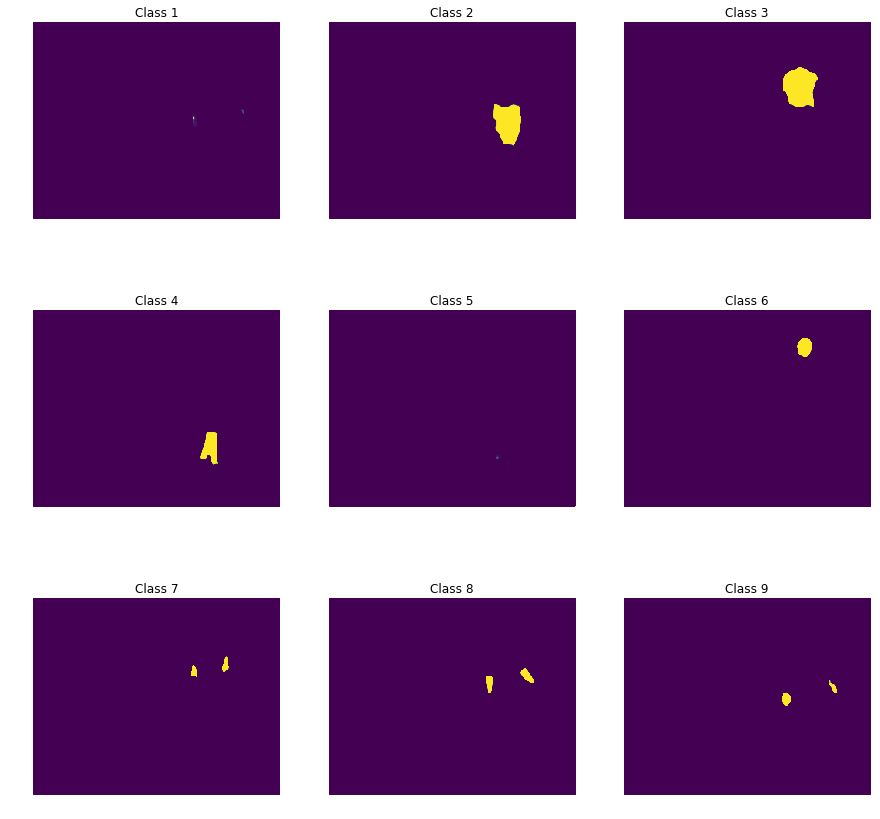

In [28]:
inputs, classes = next(iter(test_loader))
input_img = torch.unsqueeze(Variable(inputs.cuda(async=True)), dim=0)[0]
model.cuda()
model.eval()
output = model(input_img).data.cpu().numpy()

show_pics(output[3], 3, 3)

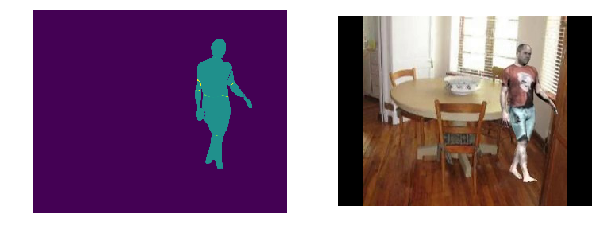

In [29]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.sum(output[3], axis=0))
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(plt.imread(test_loader.dataset.get_curr_pic()))
plt.axis('off');

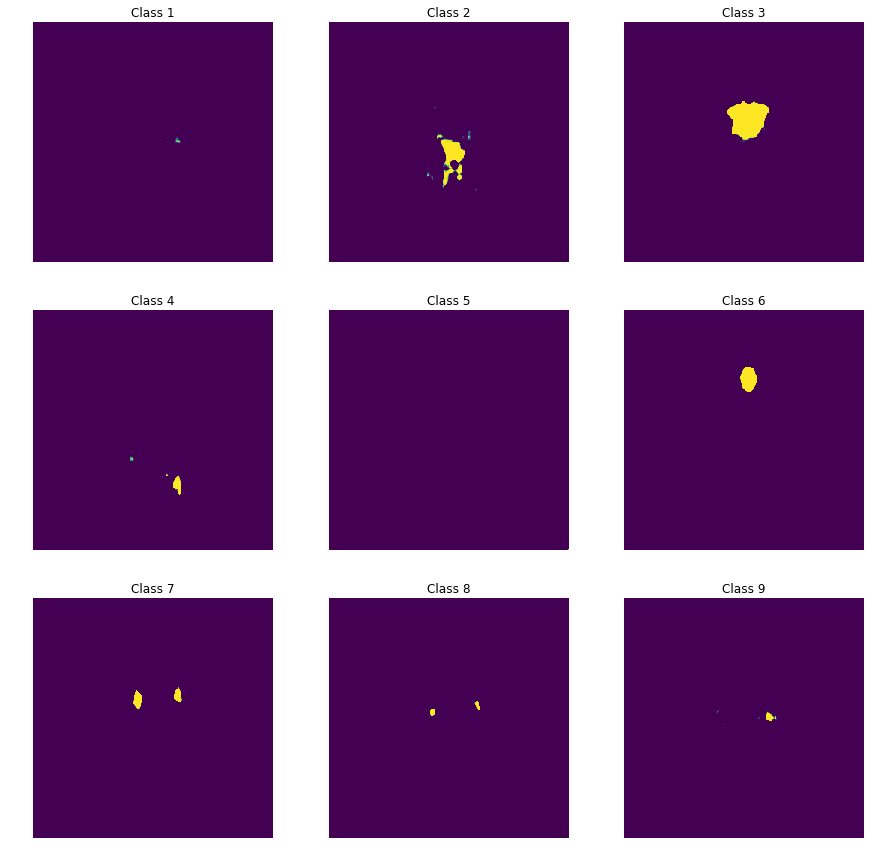

In [34]:
inputs_sit, classes_sit = next(iter(sitting_loader))
input_img_sit = torch.unsqueeze(Variable(inputs_sit.cuda(async=True)), dim=0)[0]
model.cuda()
model.eval()
output_sit = model(input_img_sit).data.cpu().numpy()

show_pics(output_sit[3], 3, 3)

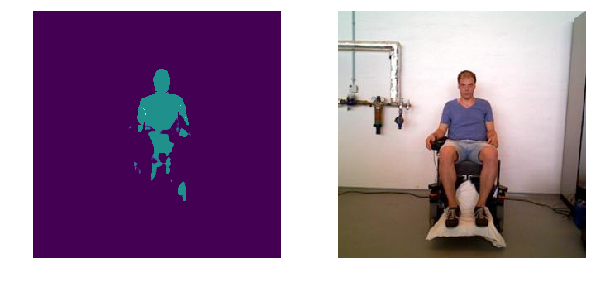

In [35]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.sum(output_sit[3], axis=0))
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(plt.imread(sitting_loader.dataset.get_curr_pic()))
plt.axis('off');

## Loss story:

In [81]:
loss_tr = np.zeros((num_epochs))
for j in [k for k in os.listdir('params/') if 'ternaus' in k ]:
    loss_tr[int(j.split('_')[1][-2:])-1] = (torch.load('params/'+j)['min_loss'])

Text(0.5,0,'Number of epoch')

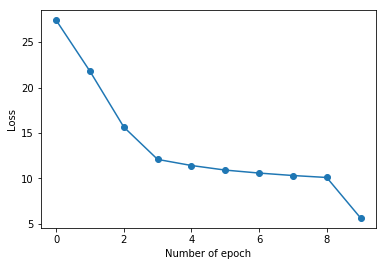

In [84]:
plt.plot(np.arange(0, num_epochs), loss_tr, '-o')
plt.ylabel('Loss')
plt.xlabel('Number of epoch')

**Not normalized loss :(**

## Domain Adaptation Theory

$X$ - input space, $Y = {0, 1, \dots, L-1}$ - set of possible labels.<br>
*Source domain* $D_{S}$ and *target domain* $D_{T}$ are two *different* distributions over $X\times Y$.

An *unsupervised domain adaptation* learning algorithm is then provided with a *labeled source sample* $S$ drawn $i.i.d.$ from $D_{S}$, and *unlabeled target sample* $T$ drawn $i.i.d.$ from $D_{T}^{X}$ - *marginal distribution* of $D_{T}$ over X,

* $\quad S = \{(x_i, y_i)\}_{i=1}^{n} \sim (D_{S})^{n}, \quad T = \{x_{i}\}_{n+1}^{N} \sim (D_{T}^{X})^{n'}$,

with $N = n + n'$ being the total number of samples. The goal of learning algotithm is to build a classifier $\eta : X \rightarrow Y$ with a low **target risk**

* $ \quad R_{D_{T}}(\eta) = Pr_{(x, y) \sim D_{T}}(\eta(x) \neq y)$,

while having no information about labels of $D_{T}$.

(In definition 1 below the hypothesis class $ \mathscr{H}$ is (discrete or continuous) set of binary classifiers $\eta : X \rightarrow \{0, 1\}$. However Ben-David mentions that same analysis holds for multiclass settings. However, to obtain the same results when $|Y| \gt 2$, one should assume that \mathscr{H} is a symmetrical hypothesis class. That is, for all $h \in \mathscr{H}$ and any permutation of labels $c : Y \rightarrow Y$ we have $c(h) \in \mathscr{H}$.)

### Theorem (Ben-David et al., 2006):

Let $\large \mathscr{H}$ be a *hypothessis class* of Vapnik–Chervonenkis(VC) dimension d. With probability $1 - \delta$ over the choice of samples $S \sim (D_{s})^{n}$ and $T \sim (D_{T}^{X})^{n}$ for every $\eta \in \large \mathscr{H}$: 

* $ \quad R_{D_{T}}(\eta) \leq R_{S}(\eta) + \sqrt{\frac{4}{n} (d \log{\frac{2en}{d}} + log{\frac{4}{\delta}})} + \hat{d}_{\mathscr{H}}(S, T) +  4\sqrt{\frac{1}{n} (d \log{\frac{2n}{d}} + log{\frac{4}{\delta}})}  + \beta$, 

with $\beta \geq \inf\limits_{\substack \eta^{*}\in\mathscr{H}} [R_{D_{T}}(\eta^*) + R_{D_{S}}(\eta)]$, and

*  $ \quad R_{S}(\eta) = \frac{1}{n} \sum\limits_{i=1}^{m} I[\eta(x_i) \neq y_i]$

is the *empirical source risk*.


* $R_{D_{T}}(\eta)$ can be low *only* when the $\beta$ term is low, *i.e.*, only when there *exist a classifier that can achieve a low risk on both distributions*. Also this theorem tells us to find a classifier with small $R_{D_{T}}(\eta)$ in a give class of fixed VC dimension, the learning algorithm should minimize (in that class) a trade-off between **the source risk** $R_{S}(\eta)$ and the **empirical $\large \mathscr{H}-$divergence** $\hat{d}_{\mathscr{H}}(S, T)$.

# *In progress*